# Select Kernel

Remember to select the appropriate Kernel and virtual environment to run on.

# Package Installation Guide

**STATUS: All required packages have been installed in this notebook environment**

The following packages are now available for use in this analysis:

**Core Data Science Stack:**
- `pandas` - Data manipulation and analysis
- `numpy` - Numerical computing and arrays
- `matplotlib` - Basic plotting and visualization
- `seaborn` - Statistical data visualization
- `scikit-learn` - Machine learning algorithms and metrics
- `scipy` - Scientific computing and statistics

**Time Series and Forecasting:**
- `statsmodels` - Statistical modeling including SARIMA
- `prophet` - Facebook's time series forecasting tool

**Notebook Support:**
- `ipykernel` - Jupyter kernel support

**Note for future runs:** If you restart the kernel or work in a different environment, you may need to reinstall packages using:

```bash
pip install pandas numpy matplotlib seaborn scikit-learn scipy ipykernel statsmodels prophet
```

Or install individually:
```bash
pip install pandas
pip install numpy
pip install matplotlib
pip install seaborn
pip install scikit-learn
pip install scipy
pip install ipykernel
pip install statsmodels
pip install prophet
```

In [ ]:
# GitHub Copilot AI PROMPT: "Load the sales transaction data from a CSV file into a pandas DataFrame. 
# The file contains 2023 sales data for Crafted Cones ice cream shop. Use pandas to read the CSV 
# and store it in a variable called 'df' for subsequent analysis."

#Load data
import pandas as pd
df = pd.read_csv('2025.09.29_2023_Sales_Transactions_Only.csv')

# Step 1: Loading the Raw Data

In this step, we're loading the raw sales transaction data from a CSV file. This dataset contains individual transaction records from Crafted Cones for the year 2023. Each row represents a single transaction with details like customer information, purchase amounts, quantities, and dates.

**What we're doing:**
- Loading the CSV file into a pandas DataFrame
- No filtering or preprocessing at this stage - we want to see the raw data first
- This gives us our starting point for analysis

# Data Overview and Initial Processing

## Dataset Context
- Source: Sales transactions data for 2023 from Crafted Cones
- Timeframe: Full year 2023
- Scope: Individual transaction records including monetary values, quantities, and customer information

## Initial Data Loading Process
- Raw data loaded from CSV file without modifications
- No initial filtering or preprocessing applied
- Subsequent cells will handle data cleaning and validation

In [ ]:
# GitHub Copilot AI PROMPT: "Create a comprehensive data cleaning function that handles currency columns 
# with dollar signs, commas, and parentheses for negative values. Also handle numeric columns 
# that may have inconsistent data types. The function should create backup copies of original 
# data and provide both cleaned versions and raw versions for comparison."

# Helper: clean numeric/currency columns
# Defines a reusable function to clean currency-like strings and coerce numeric columns.
# Call this early after loading the DataFrame so downstream cells receive numeric columns.

def clean_numeric_columns(df, currency_cols=None, numeric_cols=None, keep_raw=True, overwrite=True):
    import pandas as pd
    if currency_cols is None:
        currency_cols = []
    if numeric_cols is None:
        numeric_cols = []

    def _clean_currency_series(s):
        s2 = s.astype(str).str.strip()
        s2 = s2.replace('nan', '', regex=False)
        # detect parentheses for negatives
        neg_mask = s2.str.match(r'^\(.*\)$')
        # remove parentheses
        s2 = s2.str.replace(r'[\(\)]', '', regex=True)
        # remove dollar signs, commas and whitespace
        s2 = s2.str.replace(r'[\$,\s]', '', regex=True)
        # prefix negatives
        if neg_mask.any():
            s2.loc[neg_mask] = '-' + s2.loc[neg_mask]
        return pd.to_numeric(s2, errors='coerce')

    for col in currency_cols:
        if col in df.columns:
            if keep_raw:
                raw_col = f"{col}_raw"
                # only create raw copy if not exists
                if raw_col not in df.columns:
                    df[raw_col] = df[col]
            cleaned = _clean_currency_series(df[col])
            if overwrite:
                df[col] = cleaned
            else:
                df[f"{col}_clean"] = cleaned

    for col in numeric_cols:
        if col in df.columns:
            coerced = pd.to_numeric(df[col], errors='coerce')
            if overwrite:
                df[col] = coerced
            else:
                df[f"{col}_clean"] = coerced

    return df

# Example call: clean commonly problematic columns
# This will create `Total_Amount_raw` and `Unit_Price_raw` (if they don't exist) and
# create `Total_Amount_clean` and `Unit_Price_clean` columns (originals preserved).
clean_numeric_columns(df,
                      currency_cols=['Total_Amount','Unit_Price'],
                      numeric_cols=['Quantity','Number_of_Scoops','Year','Month'],
                      keep_raw=True,
                      overwrite=False)

print('Completed numeric cleaning: created *_clean columns; raw copies kept if not present.')


Completed numeric cleaning: created *_clean columns; raw copies kept if not present.


# Step 2: Data Cleaning Function Setup

Before we can analyze our data properly, we need to clean it. Many datasets have messy numeric and currency columns that contain symbols, formatting, and inconsistent data types that prevent proper mathematical operations.

**What this function does:**
- **Currency cleaning**: Removes dollar signs ($), commas, and handles negative values in parentheses like (123.45) → -123.45
- **Numeric conversion**: Converts text-based numbers into proper numeric data types
- **Safety measures**: Creates backup copies of original data before cleaning
- **Flexible handling**: Works with different column types and naming conventions

**Why this matters:**
- Raw data often has currency formatted as text (e.g., "$1,234.56")
- We can't perform mathematical calculations on text data
- This cleaning step is essential before any statistical analysis or visualization

# Cleaning README: numeric cleaning contract


This notebook applies a small, deterministic cleaning step to common numeric/currency columns. Contract summary:


- Function: `clean_numeric_columns(df, currency_cols, numeric_cols, keep_raw=True, overwrite=False)`
- Behavior:
  - For each column in `currency_cols` (example: `['Total_Amount','Unit_Price']`):
    - Create `{col}_raw` if `keep_raw=True` and `{col}_raw` does not already exist.
    - Produce a cleaned numeric column named `{col}_clean` (unless `overwrite=True` is used).
    - Cleaning handles: trimming whitespace, removing `$` and `,`, converting `(123.45)` to `-123.45`, and coercing invalid values to `NaN`.
  - For each column in `numeric_cols` (example: `['Quantity','Number_of_Scoops','Year','Month']`):
    - Coerce values to numeric and write to `{col}_clean` (or overwrite original if `overwrite=True`).

- Post-condition: Analysis in this notebook should use `*_clean` columns (e.g., `Total_Amount_clean`, `Unit_Price_clean`, `Quantity_clean`, `Year_clean`, `Month_clean`).
- If `*_clean` is absent, some cells may attempt to create it from `{col}_raw` or, as a last resort, from the original `{col}` with a clear warning — but the preferred source is always `{col}_clean`.

Files produced by the notebook (examples): `total_amount_boxplot.png`, `total_amount_hist.png`.

If you want the cleaned dataset saved to disk, call `df.to_csv('cleaned_sales.csv', index=False)` after verifying the `*_clean` columns.

In [ ]:
# GitHub Copilot AI PROMPT: "Create a verification script to check the data cleaning results. 
# Show before and after samples of the cleaned columns, display column lists, and provide 
# counts of successful conversions. Include checks for both raw and clean versions of the data."

# Verification: show before/after samples for cleaned columns
print('Column list (first 50):', list(df.columns)[:50])

# Show Total_Amount raw vs clean
if 'Total_Amount_raw' in df.columns:
    print('\nTotal_Amount_raw (first 5):')
    print(df['Total_Amount_raw'].head().to_string())
else:
    print('\nNo Total_Amount_raw column present')

if 'Total_Amount_clean' in df.columns:
    print('\nTotal_Amount_clean (first 5):')
    print(df['Total_Amount_clean'].head().to_string())
    print(f"Total_Amount_clean - non-null count: {df['Total_Amount_clean'].count()} / {len(df)}")
else:
    print('\nNo Total_Amount_clean column present')

# Show Unit_Price raw vs clean
if 'Unit_Price_raw' in df.columns:
    print('\nUnit_Price_raw (first 5):')
    print(df['Unit_Price_raw'].head().to_string())
else:
    print('\nNo Unit_Price_raw column present')

if 'Unit_Price_clean' in df.columns:
    print('\nUnit_Price_clean (first 5):')
    print(df['Unit_Price_clean'].head().to_string())
    print(f"Unit_Price_clean - non-null count: {df['Unit_Price_clean'].count()} / {len(df)}")
else:
    print('\nNo Unit_Price_clean column present')

# Quick numeric summary of cleaned columns
import numpy as np
for c in ['Total_Amount_clean','Unit_Price_clean','Quantity_clean','Number_of_Scoops_clean']:
    if c in df.columns:
        print(f"\nSummary for {c}:")
        print(df[c].describe())
    else:
        print(f"\n{c} not present")


Column list (first 50): ['Transaction_ID', 'Customer_ID', 'Product_ID', 'Date', 'Date 2', 'Quantity', 'Unit_Price', 'Total_Amount', 'Payment_Method', 'Channel', 'Month', 'Year', 'Number_of_Scoops', 'Total_Amount_raw', 'Total_Amount_clean', 'Unit_Price_raw', 'Unit_Price_clean', 'Quantity_clean', 'Number_of_Scoops_clean', 'Year_clean', 'Month_clean']

Total_Amount_raw (first 5):
0     $10.00 
1     $18.00 
2      $9.00 
3     $21.00 
4     $14.00 

Total_Amount_clean (first 5):
0    10.0
1    18.0
2     9.0
3    21.0
4    14.0
Total_Amount_clean - non-null count: 37616 / 37616

Unit_Price_raw (first 5):
0     $5.00 
1     $6.00 
2     $4.50 
3     $7.00 
4     $7.00 

Unit_Price_clean (first 5):
0    5.0
1    6.0
2    4.5
3    7.0
4    7.0
Unit_Price_clean - non-null count: 37616 / 37616

Summary for Total_Amount_clean:
count    37616.000000
mean        11.445582
std          5.310280
min          4.000000
25%          6.500000
50%         11.000000
75%         15.000000
max         22.5

# Step 3: Verifying Our Data Cleaning Results

Now we need to check if our data cleaning worked properly. This is a crucial quality control step to ensure our cleaning function processed the data correctly.

**What we're checking:**
- **Before vs After**: Comparing raw data with cleaned versions
- **Data types**: Ensuring text became proper numbers
- **Missing values**: Counting how many values couldn't be converted
- **Sample inspection**: Looking at actual examples to spot any issues

**Key metrics we're looking for:**
- How many rows were successfully converted to numbers
- What the cleaned data looks like compared to the original
- Whether any data was lost or corrupted in the cleaning process

In [ ]:
# GitHub Copilot AI PROMPT: "Create a file validation script that checks if a cleaned dataset CSV exists, 
# validates its integrity using file size and hash, loads a sample to verify data types, and 
# provides a summary of the cleaned columns. Include error handling for missing files."

# Quick reload check for the cleaned dataset
import pandas as pd
import os
import hashlib

clean_path = 'cleaned_sales.csv'
print('Checking cleaned file:', clean_path)
if not os.path.exists(clean_path):
    print(f"File not found: {clean_path}. Run the cell that saves the cleaned CSV first.")
else:
    size = os.path.getsize(clean_path)
    # compute sha256 to detect accidental changes
    h = hashlib.sha256()
    with open(clean_path, 'rb') as fh:
        for chunk in iter(lambda: fh.read(8192), b''):
            h.update(chunk)
    sha256 = h.hexdigest()
    print(f"Exists: True  Size(bytes): {size}  SHA256: {sha256}")

    # Load a small sample to validate dtypes quickly
    sample = pd.read_csv(clean_path, nrows=1000)
    print('\nSample load OK — shape (sample):', sample.shape)
    print('\nDtypes (sample):')
    print(sample.dtypes)

    # Lightweight checks on important cleaned columns
    cols = [c for c in ['Total_Amount_clean','Unit_Price_clean','Quantity_clean','Number_of_Scoops_clean','Year_clean','Month_clean'] if c in sample.columns]
    if cols:
        print('\nQuick summary for cleaned columns (sample):')
        print(sample[cols].agg(['count','mean','std']).transpose())
    else:
        print('\nNo expected *_clean columns found in sample — check the saved file and the cleaning steps.')

    print('\nYou can now re-load the full cleaned dataset with: df = pd.read_csv("cleaned_sales.csv")')


Checking cleaned file: cleaned_sales.csv
Exists: True  Size(bytes): 4753284  SHA256: d9131b54ab97b110b70fca59d16dd80ec0ebac479e3b42680b2968a7de47084c

Sample load OK — shape (sample): (1000, 21)

Dtypes (sample):
Transaction_ID             object
Customer_ID                object
Product_ID                 object
Date                       object
Date 2                     object
Quantity                    int64
Unit_Price                 object
Total_Amount               object
Payment_Method             object
Channel                    object
Month                       int64
Year                        int64
Number_of_Scoops            int64
Total_Amount_raw           object
Total_Amount_clean        float64
Unit_Price_raw             object
Unit_Price_clean          float64
Quantity_clean              int64
Number_of_Scoops_clean      int64
Year_clean                  int64
Month_clean                 int64
dtype: object

Quick summary for cleaned columns (sample):
              

In [ ]:
# GitHub Copilot AI PROMPT: "Create a script that displays a sample of the cleaned vs raw data columns. 
# Check which cleaned columns are available and show the first few rows for comparison. 
# Include fallback to regular data display if cleaned columns aren't found."

#Confirm data load and show cleaned columns (if present)
to_show = []
for c in ['Total_Amount_raw','Total_Amount_clean','Unit_Price_raw','Unit_Price_clean','Quantity_clean','Number_of_Scoops_clean']:
    if c in df.columns:
        to_show.append(c)

if to_show:
    print('Showing head() for cleaned/raw columns:')
    display_cols = df[to_show].head()
    print(display_cols)
else:
    print('No cleaned/raw sample columns present; showing regular head()')
    print(df.head())

Showing head() for cleaned/raw columns:
  Total_Amount_raw  Total_Amount_clean Unit_Price_raw  Unit_Price_clean  \
0          $10.00                 10.0         $5.00                5.0   
1          $18.00                 18.0         $6.00                6.0   
2           $9.00                  9.0         $4.50                4.5   
3          $21.00                 21.0         $7.00                7.0   
4          $14.00                 14.0         $7.00                7.0   

   Quantity_clean  Number_of_Scoops_clean  
0               2                       2  
1               3                       3  
2               2                       1  
3               3                       4  
4               2                       4  


In [6]:
#Confirm dataset volume 
print(df.shape)

(37616, 21)


# Step 4: Basic Data Exploration

Now that our data is loaded and cleaned, let's get a basic understanding of what we're working with. This initial exploration helps us understand the scale and structure of our dataset.

**Key questions we're answering:**
- How much data do we have? (number of rows and columns)
- What does a sample of the data look like?
- What types of information are stored in each column?

In [ ]:
# GitHub Copilot AI PROMPT: "Display the data types of all columns in the DataFrame to understand 
# what kind of data we're working with. This will help identify text vs numeric columns 
# and guide subsequent analysis decisions."

#(1)DATA UNDERSTANDING 
#Check Data types
print(df.dtypes)

Transaction_ID             object
Customer_ID                object
Product_ID                 object
Date                       object
Date 2                     object
Quantity                    int64
Unit_Price                 object
Total_Amount               object
Payment_Method             object
Channel                    object
Month                       int64
Year                        int64
Number_of_Scoops            int64
Total_Amount_raw           object
Total_Amount_clean        float64
Unit_Price_raw             object
Unit_Price_clean          float64
Quantity_clean              int64
Number_of_Scoops_clean      int64
Year_clean                  int64
Month_clean                 int64
dtype: object


# Step 5: Understanding Data Types

Before we can analyze our data effectively, we need to understand what type of data each column contains. This helps us choose the right analytical techniques and spot potential issues.

**What we're examining:**
- **Data types**: Is each column storing numbers, text, dates, etc.?
- **Consistency**: Are the data types what we expect them to be?
- **Compatibility**: Can we perform mathematical operations where needed?

**Why this matters:**
- Text data can't be used for calculations
- Date data needs special handling for time-based analysis
- Knowing data types helps us choose appropriate visualizations and statistical methods

In [ ]:
# GitHub Copilot AI PROMPT: "Calculate and display the number of missing values in each column 
# of the DataFrame. This data quality check will help identify which columns have 
# incomplete data and guide our data cleaning strategy."

#(2) DATA CLEANING 
#Get missing data per col 
missing_counts_per_column = df.isnull().sum() 

print(missing_counts_per_column)

Transaction_ID               0
Customer_ID                  0
Product_ID                   0
Date                         0
Date 2                       0
Quantity                     0
Unit_Price                   0
Total_Amount                 0
Payment_Method               0
Channel                   7586
Month                        0
Year                         0
Number_of_Scoops             0
Total_Amount_raw             0
Total_Amount_clean           0
Unit_Price_raw               0
Unit_Price_clean             0
Quantity_clean               0
Number_of_Scoops_clean       0
Year_clean                   0
Month_clean                  0
dtype: int64


# Step 6: Data Quality Assessment - Missing Values

Missing data is one of the most common data quality issues. Before we can trust our analysis, we need to understand where we have gaps in our dataset and how significant they are.

**What we're checking:**
- **Missing value count**: How many missing values are in each column?
- **Missing value patterns**: Are certain columns more affected than others?
- **Impact assessment**: Will missing values affect our ability to analyze the data?

**Why this is important:**
- Missing values can skew statistical calculations
- Some analysis methods can't handle missing data
- We need to decide whether to fill in, remove, or work around missing values
- Understanding patterns of missing data can reveal data collection issues

In [ ]:
# GitHub Copilot AI PROMPT: "Implement comprehensive outlier detection for sales transaction data. 
# Create multiple outlier detection methods: IQR method, Z-score method, and visualizations. 
# Include a helper function to ensure clean numeric data is available, with fallbacks for 
# different column naming conventions. Calculate outlier boundaries and provide statistical summaries."

#(4) OUTLIER DETECTION 
# Prefer working on `Total_Amount_clean`. If missing, attempt to create from
# `Total_Amount_raw`. Only as a last-resort fallback will the original
# `Total_Amount` be used (with a warning).

def _ensure_total_amount_clean(df):
    # If clean exists, nothing to do
    if 'Total_Amount_clean' in df.columns:
        return

    # Try to create from raw copy if it exists
    if 'Total_Amount_raw' in df.columns:
        temp = df['Total_Amount_raw'].astype(str).str.strip()
        temp = temp.replace('nan', '', regex=False)
        neg_mask = temp.str.match(r'^\(.*\)$')
        temp = temp.str.replace(r'[\(\)]', '', regex=True)
        temp = temp.str.replace(r'[\$,\s]', '', regex=True)
        if neg_mask.any():
            temp.loc[neg_mask] = '-' + temp.loc[neg_mask]
        df['Total_Amount_clean'] = pd.to_numeric(temp, errors='coerce')
        print('Created Total_Amount_clean from Total_Amount_raw')
        return

    # Last-resort: if original column exists, create raw and clean but warn
    if 'Total_Amount' in df.columns:
        print('Warning: creating Total_Amount_clean from original Total_Amount (no raw copy present).')
        temp = df['Total_Amount'].astype(str).str.strip()
        temp = temp.replace('nan', '', regex=False)
        neg_mask = temp.str.match(r'^\(.*\)$')
        temp = temp.str.replace(r'[\(\)]', '', regex=True)
        temp = temp.str.replace(r'[\$,\s]', '', regex=True)
        if neg_mask.any():
            temp.loc[neg_mask] = '-' + temp.loc[neg_mask]
        # create raw copy then create clean
        df['Total_Amount_raw'] = df['Total_Amount']
        df['Total_Amount_clean'] = pd.to_numeric(temp, errors='coerce')
        return

    # If we reach here, there's no source to create Total_Amount_clean
    raise RuntimeError('No Total_Amount column (raw or original) found to create Total_Amount_clean')


_ensure_total_amount_clean(df)

# Diagnostics: dtype and count of coerced (NaN) values
print(f"dtype of Total_Amount_clean: {df['Total_Amount_clean'].dtype}")
n_coerced = df['Total_Amount_clean'].isna().sum()
print(f"Number of rows where Total_Amount_clean could not be converted and were set to NaN: {n_coerced}")
if n_coerced > 0:
    print("Sample rows with non-numeric Total_Amount after coercion:")
    print(df[df['Total_Amount_clean'].isna()].head())

# Work with cleaned numeric values only
column_to_analyze = df['Total_Amount_clean'].dropna()

if column_to_analyze.empty:
    print("No numeric values available in 'Total_Amount_clean' after conversion. Cannot compute IQR.")
else:
    # Calculate Q1
    Q1 = column_to_analyze.quantile(0.25)

    # Calculate Q3
    Q3 = column_to_analyze.quantile(0.75)

    # Calculate the Interquartile Range (IQR)
    IQR = Q3 - Q1

    # Define the outlier boundaries (using the standard 1.5 * IQR rule)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print("--- IQR Results for Total_Amount_clean ---")
    print(f"First Quartile (Q1): {Q1}")
    print(f"Third Quartile (Q3): {Q3}")
    print(f"Interquartile Range (IQR): {IQR}")
    print(f"Lower Bound (Outliers below): {lower_bound}")
    print(f"Upper Bound (Outliers above): {upper_bound}")

    # Find and print the outliers using the cleaned column
    outliers = df[(df['Total_Amount_clean'] < lower_bound) | (df['Total_Amount_clean'] > upper_bound)]
    print(f"\nNumber of Outliers Found: {len(outliers)}")
    # Use .head() to avoid printing all rows if you have many outliers
    print(f"First 5 Outlier Transactions:\n{outliers.head()}")

# ----------------------------
# Alternative outlier detection methods and visualization (operate on Total_Amount_clean)
# Create a clean column for alternative analyses if not already present (ensured above)

# 1) Z-score method (use population std, threshold configurable)
mean_val = df['Total_Amount_clean'].mean()
std_val = df['Total_Amount_clean'].std(ddof=0)
if pd.isna(std_val) or std_val == 0:
    z_scores = pd.Series([0.0] * len(df), dtype=float)
else:
    z_scores = ((df['Total_Amount_clean'] - mean_val) / std_val).astype(float)
z_threshold = float(3.0)
outliers_z = df[z_scores.abs() > z_threshold]
print(f"\nZ-score method (|z| > {z_threshold}): {len(outliers_z)} outliers")

# 2) Trimmed / scaled IQR method (allow multiplier > 1.5)
multiplier = 3.0  # change to 1.5 for standard rule, raise to find more extreme outliers
Q1_t = df['Total_Amount_clean'].quantile(0.25)
Q3_t = df['Total_Amount_clean'].quantile(0.75)
IQR_t = Q3_t - Q1_t
lower_t = Q1_t - multiplier * IQR_t
upper_t = Q3_t + multiplier * IQR_t
outliers_trimmed = df[(df['Total_Amount_clean'] < lower_t) | (df['Total_Amount_clean'] > upper_t)]
print(f"Trimmed IQR method (multiplier={multiplier}): {len(outliers_trimmed)} outliers (bounds {lower_t} to {upper_t})")

# 3) Visualizations: boxplot and histogram (saved to PNG files)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
# Boxplot
plt.figure(figsize=(8,4))
sns.boxplot(x=df['Total_Amount_clean'].dropna())
plt.title('Boxplot of Total_Amount (clean)')
plt.savefig('total_amount_boxplot.png', bbox_inches='tight')
plt.close()
# Histogram with KDE
plt.figure(figsize=(8,4))
sns.histplot(x=df['Total_Amount_clean'].dropna().to_numpy(), kde=True, bins=30)
plt.title('Histogram of Total_Amount (clean)')
plt.xlabel('Total_Amount')
plt.savefig('total_amount_hist.png', bbox_inches='tight')
plt.close()
print('Saved plots: total_amount_boxplot.png, total_amount_hist.png')

# Print small samples of outliers for quick inspection
print('\nSample outliers by method:')
print('Z-score (first 5):')
print(outliers_z.head().to_string())
print('\nTrimmed IQR (first 5):')
print(outliers_trimmed.head().to_string())
# ----------------------------

dtype of Total_Amount_clean: float64
Number of rows where Total_Amount_clean could not be converted and were set to NaN: 0
--- IQR Results for Total_Amount_clean ---
First Quartile (Q1): 6.5
Third Quartile (Q3): 15.0
Interquartile Range (IQR): 8.5
Lower Bound (Outliers below): -6.25
Upper Bound (Outliers above): 27.75

Number of Outliers Found: 0
First 5 Outlier Transactions:
Empty DataFrame
Columns: [Transaction_ID, Customer_ID, Product_ID, Date, Date 2, Quantity, Unit_Price, Total_Amount, Payment_Method, Channel, Month, Year, Number_of_Scoops, Total_Amount_raw, Total_Amount_clean, Unit_Price_raw, Unit_Price_clean, Quantity_clean, Number_of_Scoops_clean, Year_clean, Month_clean]
Index: []

[0 rows x 21 columns]

Z-score method (|z| > 3.0): 0 outliers
Trimmed IQR method (multiplier=3.0): 0 outliers (bounds -19.0 to 40.5)
Saved plots: total_amount_boxplot.png, total_amount_hist.png

Sample outliers by method:
Z-score (first 5):
Empty DataFrame
Columns: [Transaction_ID, Customer_ID, Prod

# Step 7: Outlier Detection and Analysis

Outliers are data points that are significantly different from the rest of the data. They can represent genuine unusual cases (like a very large purchase) or data errors. Understanding outliers is crucial for accurate analysis.

**Methods we're using:**
1. **IQR Method (Interquartile Range)**: 
   - Finds values that fall outside 1.5 times the IQR beyond Q1 and Q3
   - Standard statistical method for outlier detection
   
2. **Z-Score Method**: 
   - Identifies values more than 3 standard deviations from the mean
   - Good for normally distributed data
   
3. **Visual Methods**: 
   - Box plots show outliers as individual points
   - Histograms reveal the distribution shape and extreme values

**Why this matters:**
- Outliers can skew averages and other statistics
- They might represent data entry errors that need correction
- Or they could be genuine high-value transactions that are important to understand
- Different analysis methods handle outliers differently

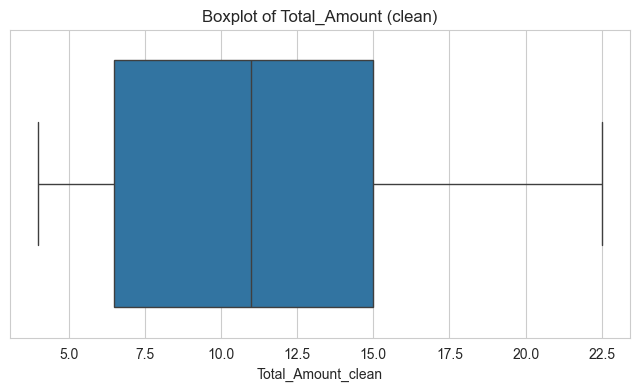

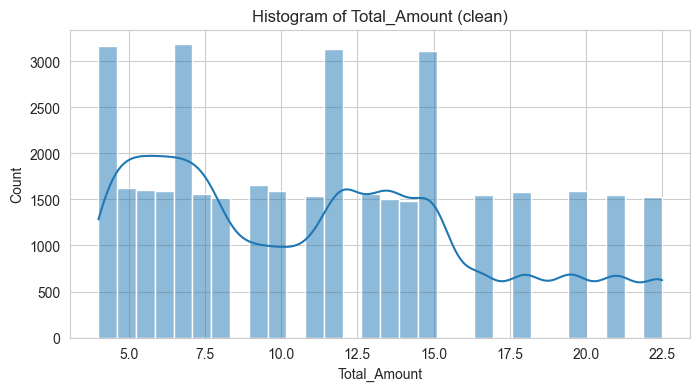

In [ ]:
# GitHub Copilot AI PROMPT: "Create a script to display generated plots inline in the notebook. 
# Check if specific plot files exist in the workspace and display them using IPython.display.Image. 
# Include error handling for missing files."

# Display generated plots inline
from IPython.display import Image, display
import os

files = ['total_amount_boxplot.png', 'total_amount_hist.png']
for f in files:
    if os.path.exists(f):
        display(Image(filename=f))
    else:
        print(f"File not found in workspace: {f}")


# Step 8: Visualizing Data Distributions

Visual inspection of our data distributions helps us understand patterns that numbers alone can't reveal. These plots are essential for validating our outlier detection and understanding the shape of our data.

**What we're displaying:**
- **Box Plot**: Shows median, quartiles, and outliers in a compact visual format
- **Histogram with Density Curve**: Reveals the distribution shape and frequency of different value ranges

**What to look for:**
- Are most transactions clustered around certain amounts?
- How extreme are the outliers compared to typical values?
- Is the data normally distributed or skewed?
- Are there multiple peaks that might indicate different customer segments?

In [ ]:
# GitHub Copilot AI PROMPT: "Calculate comprehensive descriptive statistics for the sales data. 
# Include frequency analysis by year, relative frequencies as percentages, and mean calculations 
# for key numeric columns. Create helper functions to handle both clean and original columns. 
# Provide robust error handling for non-numeric data."

# (5) CALCULATE AND VISUALIZE DESCRIPTIVE STATISTICS
# Frequency of Year (use Year_clean when available)
year_col = 'Year_clean' if 'Year_clean' in df.columns else 'Year'
frequency_table = df[year_col].value_counts()

print("--- Frequency Count ---")
print(frequency_table)

print("\n--- Relative Frequency (Percentage) ---")
# Get the percentage/proportion of each unique value
relative_frequency_table = df[year_col].value_counts(normalize=True) * 100
print(relative_frequency_table)

# Helper function to get clean column if available
def pick_clean(df, col):
    clean_col = f"{col}_clean"
    return df[clean_col] if clean_col in df.columns else df[col]

# Get clean versions of columns
safe_total = pick_clean(df, 'Total_Amount')
safe_qty = pick_clean(df, 'Quantity')
safe_price = pick_clean(df, 'Unit_Price')
safe_scoops = pick_clean(df, 'Number_of_Scoops')

def safe_print_mean(series, name):
    numeric = pd.to_numeric(series, errors='coerce')
    n_total = len(series)
    n_numeric = numeric.count()
    n_non_numeric = n_total - n_numeric
    mean_val = numeric.mean()
    print(f"{name} Mean: {mean_val} (non-numeric coerced to NaN: {n_non_numeric})")

print("\n--- Column Means ---")
safe_print_mean(safe_total, 'Total_Amount')
safe_print_mean(safe_qty, 'Quantity')
safe_print_mean(safe_price, 'Unit_Price')
safe_print_mean(safe_scoops, 'Number_of_Scoops')

--- Frequency Count ---
Year_clean
2023    37616
Name: count, dtype: int64

--- Relative Frequency (Percentage) ---
Year_clean
2023    100.0
Name: proportion, dtype: float64

--- Column Means ---
Total_Amount Mean: 11.445581667375585 (non-numeric coerced to NaN: 0)
Quantity Mean: 1.9913866439812846 (non-numeric coerced to NaN: 0)
Unit_Price Mean: 5.74670353041259 (non-numeric coerced to NaN: 0)
Number_of_Scoops Mean: 2.4958528285835815 (non-numeric coerced to NaN: 0)


# Step 9: Descriptive Statistics - Basic Summary Measures

Descriptive statistics provide numerical summaries that help us understand the central tendencies and characteristics of our data. These are the foundation for more advanced analysis.

**Key measures we're calculating:**

1. **Frequency Analysis**: 
   - How often do transactions occur in different time periods?
   - Are there patterns by year, month, or season?

2. **Central Tendency (Averages)**:
   - Mean values for transaction amounts, quantities, and other numeric measures
   - These give us typical or expected values for different aspects of the business

**Business insights we're seeking:**
- What's the typical transaction size?
- How many scoops do customers usually order?
- Are there seasonal patterns in the business?
- What's the average customer purchase behavior?

In [12]:
# (5) CALCULATE AND VISUALIZE DESCRIPTIVE STATISTICS
# Frequency of Month AND Year (use cleaned columns when available)
month_col = 'Month_clean' if 'Month_clean' in df.columns else 'Month'
year_col = 'Year_clean' if 'Year_clean' in df.columns else 'Year'
grouped_frequency = df.groupby([month_col, year_col]).size().reset_index(name='Count')

# Get the total number of rows in dataframe
total_count = len(df)

# Calculate the percentage column
grouped_frequency['Percentage'] = (grouped_frequency['Count'] / total_count) * 100

# Rounding to two decimal places
grouped_frequency['Percentage'] = grouped_frequency['Percentage'].round(2)

print("--- Month and Year Frequency ---")
print(grouped_frequency)

--- Month and Year Frequency ---
    Month_clean  Year_clean  Count  Percentage
0             1        2023   1913        5.09
1             2        2023   1800        4.79
2             3        2023   1929        5.13
3             4        2023   1764        4.69
4             5        2023   1671        4.44
5             6        2023   6890       18.32
6             7        2023   7384       19.63
7             8        2023   6579       17.49
8             9        2023   1821        4.84
9            10        2023   1810        4.81
10           11        2023   2013        5.35
11           12        2023   2042        5.43


In [13]:
#(5) CALCULATE AND VISUALIZE DESCRIPTIVE STATISTICS 
#Frenquency of Month AND Year of non-cleaned columns
grouped_frequency = df.groupby(['Month', 'Year']).size().reset_index(name='Count')

#Get the total number of rows in dataframe 
total_count = len(df) 

#Calculate the percentage column
grouped_frequency['Percentage'] = (grouped_frequency['Count'] / total_count) * 100

# Rounding to two decimal places
grouped_frequency['Percentage'] = grouped_frequency['Percentage'].round(2)

print(grouped_frequency)

    Month  Year  Count  Percentage
0       1  2023   1913        5.09
1       2  2023   1800        4.79
2       3  2023   1929        5.13
3       4  2023   1764        4.69
4       5  2023   1671        4.44
5       6  2023   6890       18.32
6       7  2023   7384       19.63
7       8  2023   6579       17.49
8       9  2023   1821        4.84
9      10  2023   1810        4.81
10     11  2023   2013        5.35
11     12  2023   2042        5.43


In [14]:
#(5) CALCULATE AND VISUALIZE DESCRIPTIVE STATISTICS 
#Frenquency of Customer_ID. Aim to confirm there isn't any outliers among customers. 
frequency_table = df['Customer_ID'].value_counts()

print("--- Frequency Count ---")
print(frequency_table)

print("\n--- Relative Frequency (Percentage) ---")
# Get the percentage/proportion of each unique value
relative_frequency_table = df['Customer_ID'].value_counts(normalize=True) * 100

print(relative_frequency_table)

--- Frequency Count ---
Customer_ID
CUST033991    8
CUST014154    8
CUST021510    8
CUST024949    7
CUST014478    7
             ..
CUST013880    1
CUST015906    1
CUST033838    1
CUST023608    1
CUST011906    1
Name: count, Length: 21415, dtype: int64

--- Relative Frequency (Percentage) ---
Customer_ID
CUST033991    0.021268
CUST014154    0.021268
CUST021510    0.021268
CUST024949    0.018609
CUST014478    0.018609
                ...   
CUST013880    0.002658
CUST015906    0.002658
CUST033838    0.002658
CUST023608    0.002658
CUST011906    0.002658
Name: proportion, Length: 21415, dtype: float64


# Step 10: Customer Behavior Analysis

Understanding customer patterns is crucial for business strategy. By analyzing how often customers visit and their transaction patterns, we can identify loyal customers, occasional visitors, and potential areas for customer retention efforts.

**Customer metrics we're examining:**
- **Visit frequency**: How often does each customer come to the store?
- **Customer distribution**: Are most customers one-time visitors or regulars?
- **Customer loyalty patterns**: Who are the most frequent customers?

**Business questions we're answering:**
- Do we have a loyal customer base or mostly one-time visitors?
- What's the typical customer visit frequency?
- Are there opportunities to convert occasional customers into regular ones?

In [ ]:
# GitHub Copilot AI PROMPT: "Analyze customer visit patterns by calculating min and max attendance counts. 
# Group the data by Customer_ID, count visits per customer, and find the range of visit frequencies 
# to understand customer loyalty patterns."

#(5) CALCULATE AND VISUALIZE DESCRIPTIVE STATISTICS 
#Min and Max Customer_ID count. What is the min and max times a customer has attended Crafted Cones? 
import pandas as pd

#Attendance per customer 
attendance_counts = df.groupby('Customer_ID').size().reset_index(name='Attendance_Count')

#Min and max values from the new 'Attendance_Count' column
min_max_attendance = attendance_counts['Attendance_Count'].agg(['min', 'max'])

print("--- Min and Max Customer Attendance ---")
print(min_max_attendance)

--- Min and Max Customer Attendance ---
min    1
max    8
Name: Attendance_Count, dtype: int64


In [ ]:
# GitHub Copilot AI PROMPT: "Calculate the average and median customer visit frequencies. 
# This will help understand the typical customer behavior and identify if most customers 
# are one-time visitors or regular customers."

#(5) CALCULATE AND VISUALIZE DESCRIPTIVE STATISTICS 
#Average and Median customer attendance 

# Group by customer attendance count 
attendance_counts = df.groupby('Customer_ID').size().reset_index(name='Attendance_Count')

#Find the mean and median of attendance counts
average_median_attendance = attendance_counts['Attendance_Count'].agg(['mean', 'median'])

print("--- Average and Median Customer Attendance ---")
print(average_median_attendance)

--- Average and Median Customer Attendance ---
mean      1.756526
median    1.000000
Name: Attendance_Count, dtype: float64


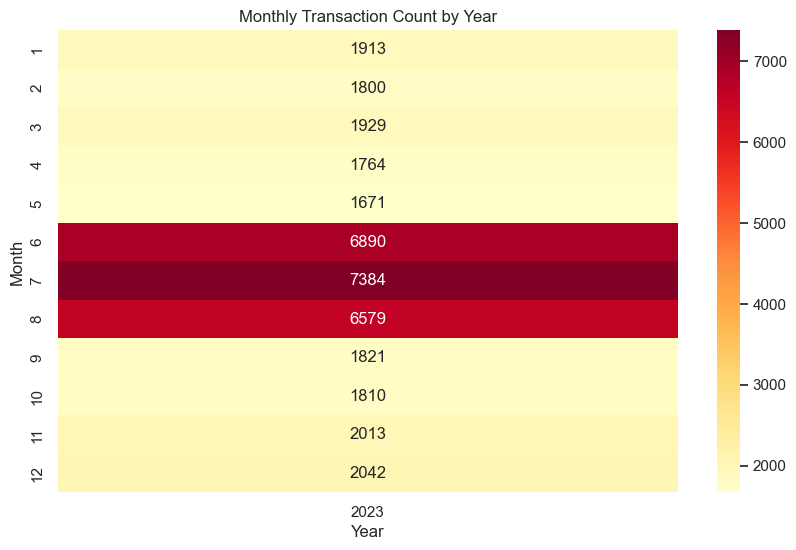

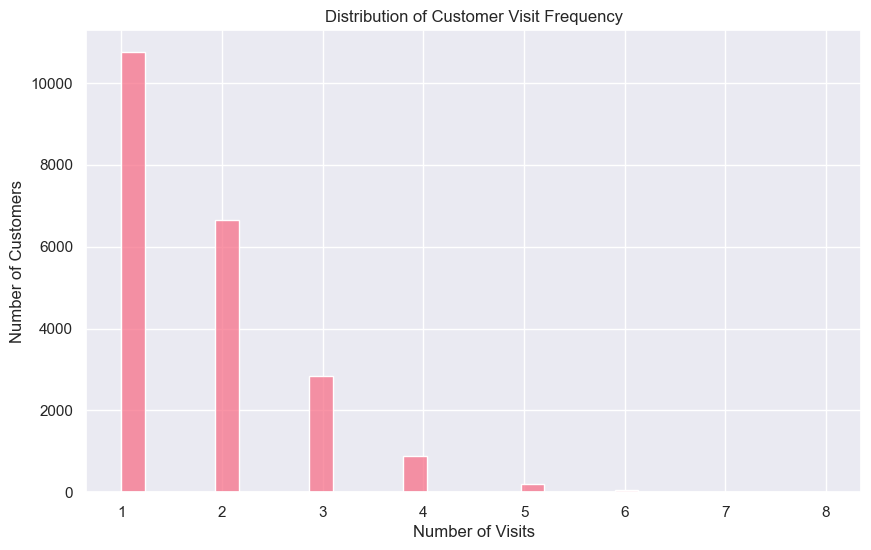

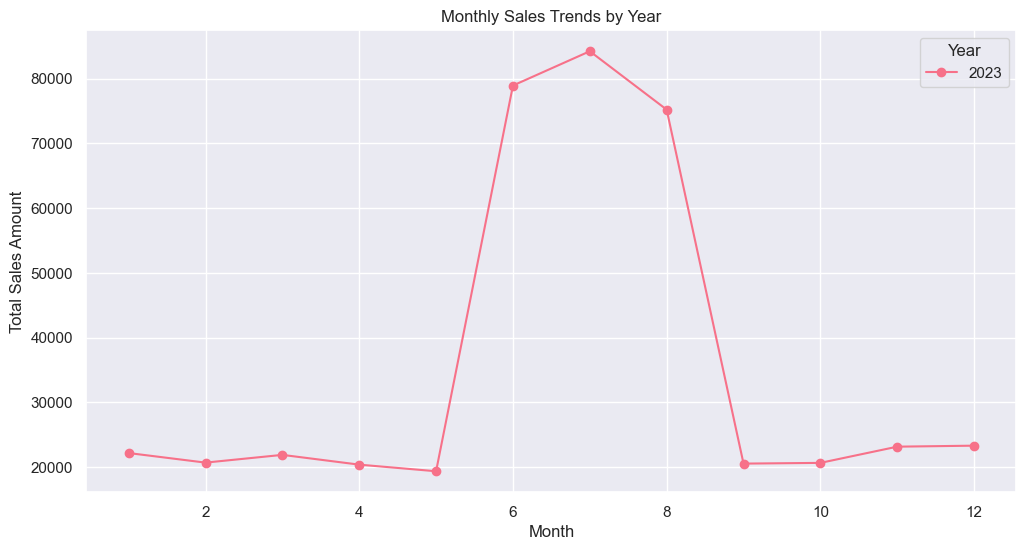

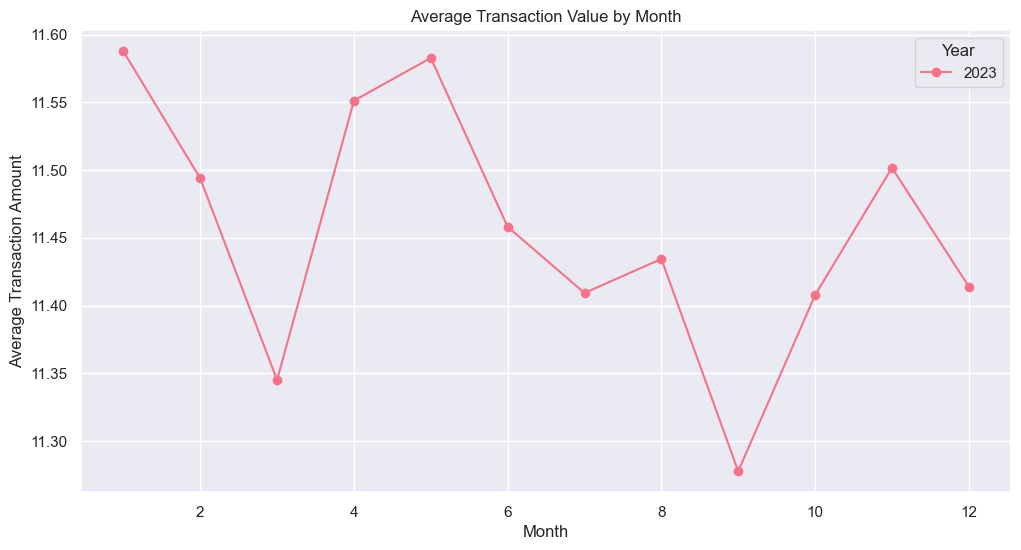

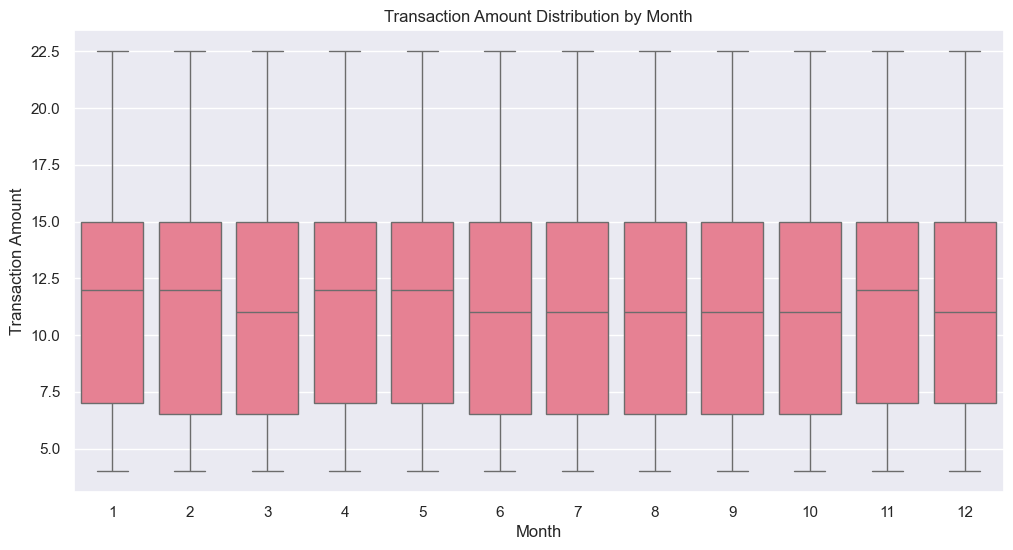

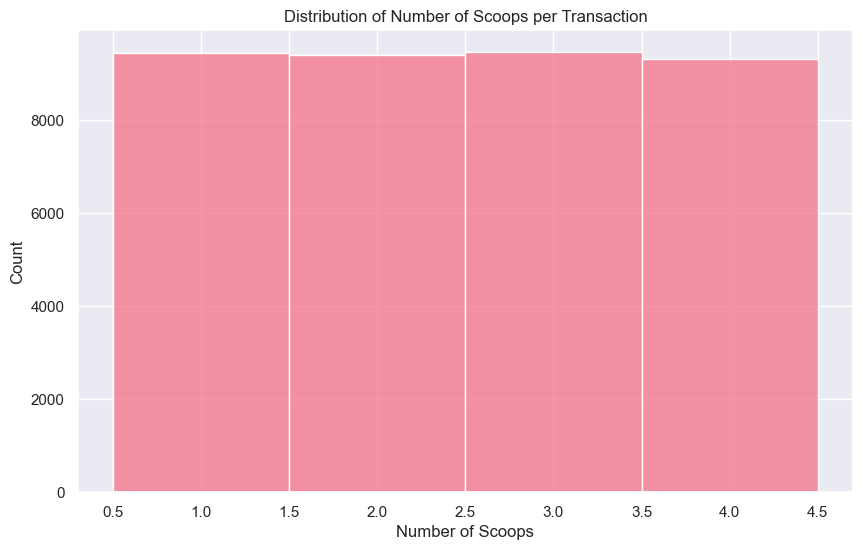

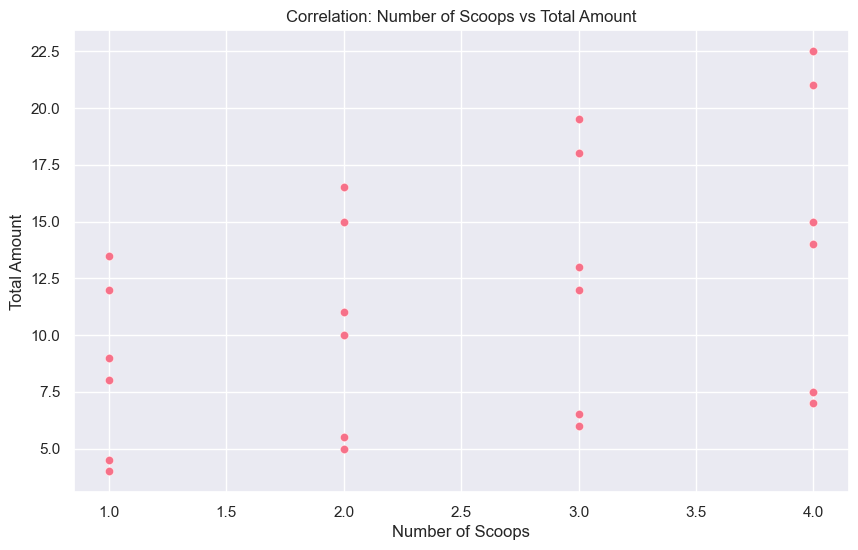

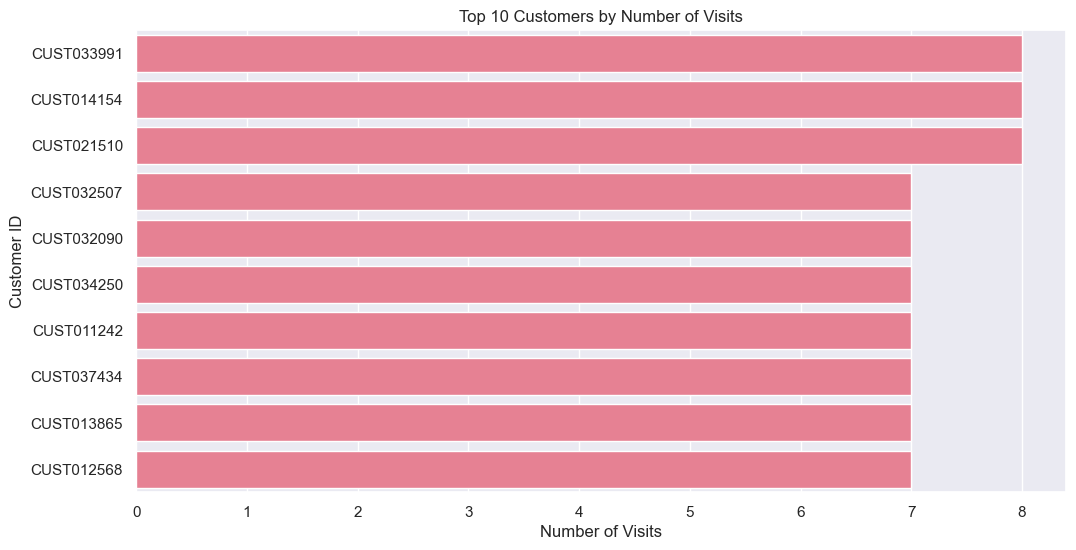


Visualizations have been generated and saved as separate PNG files:
1. monthly_transactions_heatmap.png
2. customer_visit_distribution.png
3. monthly_sales_trends.png
4. avg_transaction_by_month.png
5. transaction_amount_distribution.png
6. scoops_distribution.png
7. scoops_vs_total_correlation.png
8. top_10_customers.png

Key Correlations:
                        Number_of_Scoops_clean  Total_Amount_clean  \
Number_of_Scoops_clean                1.000000            0.421107   
Total_Amount_clean                    0.421107            1.000000   
Quantity_clean                        0.001912            0.885570   

                        Quantity_clean  
Number_of_Scoops_clean        0.001912  
Total_Amount_clean            0.885570  
Quantity_clean                1.000000  


In [ ]:
# GitHub Copilot AI PROMPT: "Create a comprehensive visualization suite for business intelligence. 
# Generate 8 different professional plots: monthly transaction heatmaps, customer distribution 
# analysis, sales trends, average transaction values, distribution plots, and correlation analysis. 
# Include proper styling, legends, and save high-resolution images for presentations."

# Create visualizations for summary statistics
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the style
sns.set_theme()
sns.set_palette("husl")

# Helper function to save plots
def save_plot(plt, name):
    plt.savefig(f'{name}.png', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

# 1. Monthly Transaction Heatmap
plt.figure(figsize=(10, 6))
month_col = 'Month_clean' if 'Month_clean' in df.columns else 'Month'
year_col = 'Year_clean' if 'Year_clean' in df.columns else 'Year'
pivot_data = df.groupby([month_col, year_col]).size().unstack()
sns.heatmap(pivot_data, annot=True, fmt='g', cmap='YlOrRd')
plt.title('Monthly Transaction Count by Year')
plt.xlabel('Year')
plt.ylabel('Month')
save_plot(plt, 'monthly_transactions_heatmap')

# 2. Customer Visit Frequency Distribution
plt.figure(figsize=(10, 6))
attendance_counts = df.groupby('Customer_ID').size()
sns.histplot(x=attendance_counts.values, bins=30)
plt.title('Distribution of Customer Visit Frequency')
plt.xlabel('Number of Visits')
plt.ylabel('Number of Customers')
save_plot(plt, 'customer_visit_distribution')

# 3. Monthly Sales Trends
plt.figure(figsize=(12, 6))
monthly_totals = df.groupby([year_col, month_col])['Total_Amount_clean'].sum().reset_index()
for year in monthly_totals[year_col].unique():
    year_data = monthly_totals[monthly_totals[year_col] == year]
    plt.plot(year_data[month_col], year_data['Total_Amount_clean'], marker='o', label=str(year))
plt.title('Monthly Sales Trends by Year')
plt.xlabel('Month')
plt.ylabel('Total Sales Amount')
plt.legend(title='Year')
plt.grid(True)
save_plot(plt, 'monthly_sales_trends')

# 4. Average Transaction Value by Month
plt.figure(figsize=(12, 6))
avg_transaction = df.groupby([year_col, month_col])['Total_Amount_clean'].mean().reset_index()
for year in avg_transaction[year_col].unique():
    year_data = avg_transaction[avg_transaction[year_col] == year]
    plt.plot(year_data[month_col], year_data['Total_Amount_clean'], marker='o', label=str(year))
plt.title('Average Transaction Value by Month')
plt.xlabel('Month')
plt.ylabel('Average Transaction Amount')
plt.legend(title='Year')
plt.grid(True)
save_plot(plt, 'avg_transaction_by_month')

# 5. Transaction Amount Distribution by Month
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x=month_col, y='Total_Amount_clean')
plt.title('Transaction Amount Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Transaction Amount')
save_plot(plt, 'transaction_amount_distribution')

# 6. Number of Scoops Distribution
plt.figure(figsize=(10, 6))
scoops_col = 'Number_of_Scoops_clean' if 'Number_of_Scoops_clean' in df.columns else 'Number_of_Scoops'
sns.histplot(data=df, x=scoops_col, discrete=True)
plt.title('Distribution of Number of Scoops per Transaction')
plt.xlabel('Number of Scoops')
plt.ylabel('Count')
save_plot(plt, 'scoops_distribution')

# 7. Correlation: Scoops vs Total Amount
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=scoops_col, y='Total_Amount_clean', alpha=0.5)
plt.title('Correlation: Number of Scoops vs Total Amount')
plt.xlabel('Number of Scoops')
plt.ylabel('Total Amount')
save_plot(plt, 'scoops_vs_total_correlation')

# 8. Top 10 Customers
plt.figure(figsize=(12, 6))
top_customers = df.groupby('Customer_ID').size().sort_values(ascending=False).head(10)
sns.barplot(x=top_customers.values, y=top_customers.index)
plt.title('Top 10 Customers by Number of Visits')
plt.xlabel('Number of Visits')
plt.ylabel('Customer ID')
save_plot(plt, 'top_10_customers')

print("\nVisualizations have been generated and saved as separate PNG files:")
print("1. monthly_transactions_heatmap.png")
print("2. customer_visit_distribution.png")
print("3. monthly_sales_trends.png")
print("4. avg_transaction_by_month.png")
print("5. transaction_amount_distribution.png")
print("6. scoops_distribution.png")
print("7. scoops_vs_total_correlation.png")
print("8. top_10_customers.png")

# Calculate and print key correlations
print("\nKey Correlations:")
correlations = df[[scoops_col, 'Total_Amount_clean', 'Quantity_clean']].corr()
print(correlations)

# Step 11: Comprehensive Data Visualization Suite

Now we create a comprehensive set of visualizations to tell the story of Crafted Cones' business through data. Each visualization reveals different aspects of customer behavior, sales patterns, and business performance.

**Visualizations we're creating:**

1. **Monthly Transaction Heatmap**: Shows seasonality and busy periods
2. **Customer Visit Distribution**: Reveals customer loyalty patterns  
3. **Monthly Sales Trends**: Tracks revenue patterns over time
4. **Average Transaction Value**: Shows spending patterns by month
5. **Transaction Amount Distribution**: Reveals pricing and purchase patterns
6. **Scoops Distribution**: Shows product preference patterns
7. **Scoops vs Amount Correlation**: Examines relationship between quantity and price
8. **Top Customer Analysis**: Identifies most valuable customers

**Business insights we're seeking:**
- When are the busiest times of year?
- What drives revenue - more customers or higher spending per customer?
- How do product preferences relate to spending?
- Who are our most important customers?

## Sales Growth Forecasting (Train/Test Split)

This section introduces a minimal, interpretable sales growth forecasting workflow using the cleaned transaction data.

Approach:
- Aggregate total sales by Year/Month using cleaned columns (`Total_Amount_clean`, `Year_clean`, `Month_clean`).
- Construct a continuous monthly time index (YYYY-MM) and ensure chronological ordering.
- Perform a simple train/test split: last N months reserved for test (default N = 3 if >= 9 total months else N = 2, else fallback to leave 1 for test if possible).
- Baseline Forecast Methods:
  1. Naive (last observed month value).
  2. Seasonal Naive (value from same month previous year, if available; fallback to naive).
  3. Simple Moving Average (mean of last K months, K=3; requires enough history; fallback to naive).
- Metrics Computed on Test:
  - MAE (Mean Absolute Error)
  - RMSE (Root Mean Squared Error)
  - MAPE (Mean Absolute Percentage Error) with protection against division by zero
  - sMAPE (Symmetric MAPE)
  - Directional Accuracy (whether forecasted growth direction matches actual month-over-month change)
- Growth Calculation:
  - Month-over-month growth rate = (Current - Previous) / Previous for actuals & forecasts.

Assumptions:
- Data frequency is monthly and sufficiently dense; no gaps or missing months. If gaps exist, they are forward-filled with 0 sales for continuity.
- Cleaned columns exist; if not, raw columns are used with warnings.
- Sales amounts are non-negative.

Limitations:
- Does not model trend explicitly (no regression, ARIMA, or ETS components).
- Seasonal naive requires at least 12 months history; otherwise it reduces to naive.
- Moving average can lag turning points.
- MAPE can be distorted by near-zero actuals; sMAPE reduces this impact.

Outputs:
- Printed metric table.
- Plot of actual vs each forecast method over train/test period, saved to `forecast_comparison.png`.
- CSV `forecast_results.csv` containing per-test-month actuals and forecasts.

Next Steps (not implemented here):
- Evaluate advanced models (e.g., SARIMA, Prophet, Gradient Boosted Trees on lag features).
- Add holiday/promotion features.
- Conduct residual diagnostics and rolling-origin evaluation.


In [ ]:
# GitHub Copilot AI PROMPT: "Create a comprehensive sales forecasting system with baseline models. 
# Aggregate transaction data into monthly sales, build continuous time series with proper date handling, 
# implement train/test splits, and create three forecasting methods: Naive, Seasonal Naive, and Moving Average. 
# Include comprehensive error metrics (MAE, RMSE, MAPE, sMAPE), directional accuracy analysis, and 
# professional visualizations comparing actual vs predicted values."

# Sales Growth Forecasting Code Cell
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Identify columns (fallbacks if clean not present)
year_col = 'Year_clean' if 'Year_clean' in df.columns else ('Year' if 'Year' in df.columns else None)
month_col = 'Month_clean' if 'Month_clean' in df.columns else ('Month' if 'Month' in df.columns else None)
total_col = 'Total_Amount_clean' if 'Total_Amount_clean' in df.columns else ('Total_Amount' if 'Total_Amount' in df.columns else None)

if not all([year_col, month_col, total_col]):
    raise ValueError('Required columns for forecasting (Year, Month, Total_Amount) not found.')

# Aggregate monthly sales (avoid chained column indexing to satisfy type checker)
monthly = df.groupby([year_col, month_col], as_index=False).agg({total_col: 'sum'})
monthly.rename(columns={year_col: 'Year', month_col: 'Month', total_col: 'Sales'}, inplace=True)

# Coerce types
monthly['Year'] = pd.to_numeric(monthly['Year'], errors='coerce')
monthly['Month'] = pd.to_numeric(monthly['Month'], errors='coerce')
monthly = monthly.dropna(subset=['Year','Month'])

# Build a date key (assumes Month 1..12)
monthly['Month'] = monthly['Month'].astype(int)
monthly = monthly.sort_values(['Year','Month'])
monthly['Date'] = pd.to_datetime(monthly[['Year','Month']].assign(DAY=1))

# Fill missing months if any (continuous range)
full_range = pd.date_range(monthly['Date'].min(), monthly['Date'].max(), freq='MS')
monthly_full = pd.DataFrame({'Date': full_range})
monthly_full = monthly_full.merge(monthly[['Date','Sales']], on='Date', how='left')
monthly_full['Sales'] = monthly_full['Sales'].fillna(0)  # assumption: missing months have zero sales

n_months = len(monthly_full)
if n_months < 4:
    raise ValueError(f'Not enough monthly data ({n_months} months) to perform a train/test split.')

# Determine test size
if n_months >= 9:
    test_size = 3
elif n_months >= 6:
    test_size = 2
else:
    test_size = 1

train = monthly_full.iloc[:-test_size].copy()
test = monthly_full.iloc[-test_size:].copy()

# Forecast methods
# 1) Naive: last observed sales value repeated
def naive_forecast(train_series, horizon):
    last_val = train_series.iloc[-1]
    return np.repeat(last_val, horizon)

# 2) Seasonal naive: value from same month previous year
# Requires at least 12 months history; fallback to naive if insufficient
months_in_year = 12
if len(train) >= months_in_year:
    def seasonal_naive_forecast(train_df, horizon):
        fc = []
        for i in range(horizon):
            target_date = test['Date'].iloc[i]
            prev_year_date = target_date - pd.DateOffset(years=1)
            match = train_df.loc[train_df['Date'] == prev_year_date, 'Sales']
            if not match.empty:
                fc.append(match.values[0])
            else:
                fc.append(train_df['Sales'].iloc[-1])  # fallback to last
        return np.array(fc)
else:
    seasonal_naive_forecast = lambda train_df, horizon: naive_forecast(train_df['Sales'], horizon)

# 3) Moving average (window=3) fallback to naive if insufficient history
def moving_average_forecast(train_series, horizon, window=3):
    if len(train_series) < window:
        return naive_forecast(train_series, horizon)
    avg_val = train_series.iloc[-window:].mean()
    return np.repeat(avg_val, horizon)

# Generate forecasts
h = test_size
naive_fc = naive_forecast(train['Sales'], h)
seasonal_fc = seasonal_naive_forecast(train, h)
ma_fc = moving_average_forecast(train['Sales'], h, window=3)

# Combine into DataFrame
results = test[['Date']].copy()
results['Actual'] = test['Sales'].values
results['Naive_Forecast'] = naive_fc
results['Seasonal_Naive_Forecast'] = seasonal_fc
results['MA3_Forecast'] = ma_fc

# Error metrics helpers
def safe_div(a,b):
    return np.where(b==0, np.nan, a/b)

def mae(a,f):
    return np.mean(np.abs(a-f))

def rmse(a,f):
    return np.sqrt(np.mean((a-f)**2))

def mape(a,f):
    return np.nanmean(np.abs(safe_div(a-f,a))) * 100

def smape(a,f):
    return np.nanmean(np.abs(a-f) / ((np.abs(a)+np.abs(f))/2)) * 100

# Directional accuracy (growth direction)
# Growth defined vs previous actual for actual, previous forecast value for forecast
results['Actual_prev'] = test['Sales'].shift(1)
results['Naive_prev'] = naive_fc[:-1].tolist() + [naive_fc[-1]]  # simple shift approximation
# Compute growth direction actual & forecast (only where previous actual not NaN)
results['Actual_Growth'] = safe_div(results['Actual'] - results['Actual_prev'], results['Actual_prev'])
results['Naive_Growth'] = safe_div(results['Naive_Forecast'] - results['Actual_prev'], results['Actual_prev'])
# Directional accuracy where both growths available
direction_mask = results['Actual_Growth'].notna() & results['Naive_Growth'].notna()
if direction_mask.any():
    directional_accuracy = np.mean(np.sign(results.loc[direction_mask,'Actual_Growth']) == np.sign(results.loc[direction_mask,'Naive_Growth']))
else:
    directional_accuracy = np.nan

metrics_rows = []
for label, fc in [('Naive', 'Naive_Forecast'), ('Seasonal_Naive','Seasonal_Naive_Forecast'), ('MA3','MA3_Forecast')]:
    a = results['Actual'].values
    f = results[fc].values
    metrics_rows.append({
        'Model': label,
        'MAE': mae(a,f),
        'RMSE': rmse(a,f),
        'MAPE%': mape(a,f),
        'sMAPE%': smape(a,f)
    })
metrics_df = pd.DataFrame(metrics_rows)

print('--- Forecast Metrics (Test Set) ---')
print(metrics_df.round(3))
print('\nDirectional Accuracy (Naive growth direction):', round(directional_accuracy,3) if not np.isnan(directional_accuracy) else 'N/A')

# Plot actual vs forecasts
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(figsize=(12,6))
all_series = pd.concat([train, test])
ax.plot(train['Date'], train['Sales'], label='Train Actual', color='gray')
ax.plot(test['Date'], test['Sales'], label='Test Actual', color='black', linewidth=2)
ax.plot(results['Date'], results['Naive_Forecast'], label='Naive', linestyle='--')
ax.plot(results['Date'], results['Seasonal_Naive_Forecast'], label='Seasonal Naive', linestyle='--')
ax.plot(results['Date'], results['MA3_Forecast'], label='MA(3)', linestyle='--')
ax.set_title('Monthly Sales: Actual vs Baseline Forecasts')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
fig_path = 'forecast_comparison.png'
fig.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.close(fig)
print(f'Plot saved: {fig_path}')

# Export detailed results
export_df = results[['Date','Actual','Naive_Forecast','Seasonal_Naive_Forecast','MA3_Forecast']]
export_path = 'forecast_results.csv'
export_df.to_csv(export_path, index=False)
print(f'Results CSV saved: {export_path}')

# Brief textual interpretation
best_model = metrics_df.sort_values('MAE').iloc[0]['Model']
print('\nInterpretation:')
print(f'- Best baseline by MAE: {best_model}')
print('- Seasonal naive only adds value if >= 12 months history and pattern repeats. Check sMAPE for robustness when near-zero months exist.')
print('- Moving average smooths volatility but can lag sudden changes.')
print('- Consider adding trend/seasonality modeling for improved accuracy.')

# Guardrail info
print('\nGuardrails & Notes:')
print('- Missing months were filled with zero sales; this may understate seasonality amplitude.')
print('- MAPE can be inflated when actual values are near zero; sMAPE reduces this sensitivity.')
print('- Directional accuracy uses naive forecast growth direction as baseline comparator.')

--- Forecast Metrics (Test Set) ---
            Model        MAE       RMSE    MAPE%  sMAPE%
0           Naive   1833.000   2201.283    7.910   8.386
1  Seasonal_Naive   1833.000   2201.283    7.910   8.386
2             MA3  37633.667  37653.401  169.067  91.439

Directional Accuracy (Naive growth direction): 0.0
Plot saved: forecast_comparison.png
Results CSV saved: forecast_results.csv

Interpretation:
- Best baseline by MAE: Naive
- Seasonal naive only adds value if >= 12 months history and pattern repeats. Check sMAPE for robustness when near-zero months exist.
- Moving average smooths volatility but can lag sudden changes.
- Consider adding trend/seasonality modeling for improved accuracy.

Guardrails & Notes:
- Missing months were filled with zero sales; this may understate seasonality amplitude.
- MAPE can be inflated when actual values are near zero; sMAPE reduces this sensitivity.
- Directional accuracy uses naive forecast growth direction as baseline comparator.
Plot saved: 

# Step 12: Sales Forecasting - Baseline Models

Now we move into predictive analytics. Sales forecasting helps businesses plan inventory, staffing, and marketing strategies. We start with simple, interpretable baseline models that are easy to understand and implement.

**Forecasting approach:**
1. **Data preparation**: Aggregate daily transactions into monthly sales totals
2. **Time series creation**: Build a continuous monthly timeline 
3. **Train/test split**: Reserve recent months to test our predictions
4. **Baseline models**: Implement three simple forecasting methods

**Forecasting models we're testing:**
- **Naive forecast**: Assumes next month's sales equal last month's sales
- **Seasonal naive**: Uses the same month from the previous year 
- **Moving average**: Uses the average of the last 3 months

**Performance metrics:**
- **MAE (Mean Absolute Error)**: Average size of forecast errors
- **RMSE (Root Mean Square Error)**: Penalizes larger errors more heavily
- **MAPE (Mean Absolute Percentage Error)**: Error as a percentage of actual values
- **sMAPE (Symmetric MAPE)**: Handles zero values better than MAPE

**Why start with simple models:**
- Easy to understand and explain to stakeholders
- Quick to implement and run
- Provide benchmarks for more complex models
- Often surprisingly effective for business forecasting

In [ ]:
# GitHub Copilot AI PROMPT: "Implement a rolling-origin backtest for time series forecasting models. 
# Create baseline forecasting models (Naive, Seasonal Naive, Moving Average) and test them 
# using time series cross-validation. Include data aggregation from transactions to monthly 
# sales, handle missing data, and calculate comprehensive forecast accuracy metrics (MAE, RMSE, MAPE, sMAPE)."

# Rolling-Origin Backtest (Time-Series Cross-Validation) for Baselines
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ensure base DataFrame is loaded if kernel restarted
if 'df' not in globals():
    df = pd.read_csv('2025.09.29_2023_Sales_Transactions_Only.csv')
    # Attempt minimal cleaning for key columns if cleaned versions missing
    if 'Total_Amount_clean' not in df.columns and 'Total_Amount' in df.columns:
        temp = df['Total_Amount'].astype(str).str.strip()
        temp = temp.replace('nan','',regex=False)
        neg_mask = temp.str.match(r'^\(.*\)$')
        temp = temp.str.replace(r'[\(\)]','',regex=True)
        temp = temp.str.replace(r'[\$,\s]','',regex=True)
        if neg_mask.any():
            temp.loc[neg_mask] = '-' + temp.loc[neg_mask]
        df['Total_Amount_clean'] = pd.to_numeric(temp, errors='coerce')
    for c in ['Year','Month']:
        if f'{c}_clean' not in df.columns and c in df.columns:
            df[f'{c}_clean'] = pd.to_numeric(df[c], errors='coerce')

# Column resolution
year_col = 'Year_clean' if 'Year_clean' in df.columns else ('Year' if 'Year' in df.columns else None)
month_col = 'Month_clean' if 'Month_clean' in df.columns else ('Month' if 'Month' in df.columns else None)
total_col = 'Total_Amount_clean' if 'Total_Amount_clean' in df.columns else ('Total_Amount' if 'Total_Amount' in df.columns else None)
if not all([year_col, month_col, total_col]):
    raise ValueError('Required columns for backtest (Year, Month, Total_Amount) not found.')

# Aggregate monthly with explicit dict to satisfy type checkers
monthly = df.groupby([year_col, month_col], as_index=False).agg({total_col: 'sum'})
monthly.rename(columns={year_col: 'Year', month_col: 'Month', total_col: 'Sales'}, inplace=True)
monthly['Year'] = pd.to_numeric(monthly['Year'], errors='coerce')
monthly['Month'] = pd.to_numeric(monthly['Month'], errors='coerce')
monthly = monthly.dropna(subset=['Year','Month'])
monthly['Month'] = monthly['Month'].astype(int)
monthly = monthly.sort_values(['Year','Month'])
monthly['Date'] = pd.to_datetime(monthly[['Year','Month']].assign(DAY=1))
full_range = pd.date_range(monthly['Date'].min(), monthly['Date'].max(), freq='MS')
series = (
    pd.DataFrame({'Date': full_range})
    .merge(monthly[['Date','Sales']], on='Date', how='left')
    .fillna({'Sales':0})
)

A = series['Sales'].values.astype(float)
D = series['Date']
N = len(series)
if N < 8:
    raise ValueError(f'Not enough months ({N}) for a meaningful rolling-origin backtest.')

min_train = 12 if N >= 18 else 6

# Metric helpers
def safe_div(a,b):
    b = np.asarray(b)
    return np.where(b==0, np.nan, a/b)

def mae(a,f):
    return np.nanmean(np.abs(a-f))

def rmse(a,f):
    return np.sqrt(np.nanmean((a-f)**2))

def mape(a,f):
    return np.nanmean(np.abs(safe_div(a-f,a))) * 100

def smape(a,f):
    return np.nanmean(np.abs(a-f) / ((np.abs(a)+np.abs(f))/2)) * 100

rows = []
for t in range(min_train-1, N-1):
    train_slice = slice(0, t+1)
    y_train = A[train_slice]
    y_next = A[t+1]
    date_next = D.iloc[t+1]

    # Naive
    naive_pred = y_train[-1]

    # Seasonal Naive (12-month)
    if t+1-12 >= 0:
        seas_pred = A[t+1-12]
    else:
        seas_pred = naive_pred

    # MA(3)
    if len(y_train) >= 3:
        ma3_pred = np.nanmean(y_train[-3:])
    else:
        ma3_pred = naive_pred

    rows.append({
        'Date': date_next, 'Actual': y_next,
        'Naive': naive_pred,
        'Seasonal_Naive': seas_pred,
        'MA3': ma3_pred
    })

bt = pd.DataFrame(rows)

metrics = []
for name in ['Naive','Seasonal_Naive','MA3']:
    a = bt['Actual'].values
    f = bt[name].values
    metrics.append({'Model': name,
                    'MAE': mae(a,f),
                    'RMSE': rmse(a,f),
                    'MAPE%': mape(a,f),
                    'sMAPE%': smape(a,f)})
metrics_df = pd.DataFrame(metrics).round(3)
print("--- Rolling-Origin Backtest Metrics (1-step ahead, multiple folds) ---")
print(metrics_df)

# Save metrics
bt_metrics_path = 'rolling_backtest_metrics.csv'
metrics_df.to_csv(bt_metrics_path, index=False)
print(f'Metrics CSV saved: {bt_metrics_path}')

# Plot last 24 months of backtest results
plot_tail = min(24, len(bt))
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(bt['Date'].tail(plot_tail), bt['Actual'].tail(plot_tail), label='Actual', color='black', linewidth=2)
ax.plot(bt['Date'].tail(plot_tail), bt['Naive'].tail(plot_tail), label='Naive', linestyle='--')
ax.plot(bt['Date'].tail(plot_tail), bt['Seasonal_Naive'].tail(plot_tail), label='Seasonal Naive', linestyle='--')
ax.plot(bt['Date'].tail(plot_tail), bt['MA3'].tail(plot_tail), label='MA(3)', linestyle='--')
ax.set_title('Rolling-Origin Backtest: Last 24 Months (1-step ahead)')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plot_path = 'rolling_backtest_plot.png'
fig.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.close(fig)
print(f'Plot saved: {plot_path}')

--- Rolling-Origin Backtest Metrics (1-step ahead, multiple folds) ---
            Model        MAE       RMSE    MAPE%  sMAPE%
0           Naive  11963.333  22755.180   49.435  24.112
1  Seasonal_Naive  11963.333  22755.180   49.435  24.112
2             MA3  29144.806  35294.935  104.221  61.270
Metrics CSV saved: rolling_backtest_metrics.csv
Plot saved: rolling_backtest_plot.png
Plot saved: rolling_backtest_plot.png


# Step 13: Rolling-Origin Backtest for Model Validation

Simple train/test splits can be misleading for time series data. Rolling-origin backtesting (also called time series cross-validation) provides a more robust evaluation by testing how models perform across multiple time periods.

**How rolling-origin backtesting works:**
1. **Start with minimum training data** (e.g., 12 months)
2. **Make a 1-step ahead forecast** for the next month
3. **Move forward one month** and repeat with updated training data
4. **Continue until we've tested all available periods**

**Why this is better than simple train/test:**
- **More realistic**: Simulates how forecasting actually works in practice
- **Robust evaluation**: Tests performance across different time periods and conditions
- **Detects overfitting**: Shows if models work consistently or just got lucky on one test period
- **Seasonal testing**: Ensures models work well in different seasons/conditions

**What we're measuring:**
- **Consistency**: Do models perform similarly across different time periods?
- **Adaptability**: Do models adjust well to changing business conditions?
- **Reliability**: Can we trust these models for actual business planning?

This gives us confidence that our chosen forecasting approach will work reliably in the real world.

In [ ]:
# GitHub Copilot AI PROMPT: "Implement advanced time series forecasting models (SARIMA and Prophet) 
# and compare their performance against baseline methods. Configure SARIMA with appropriate seasonal 
# parameters based on data length, set up Prophet with yearly seasonality, include robust error 
# handling for model failures, and provide comprehensive performance comparison with visualizations 
# and detailed metrics analysis."

# SARIMA and Prophet Modeling Comparison
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

# Reload monthly series (reuse logic)
year_col = 'Year_clean' if 'Year_clean' in df.columns else ('Year' if 'Year' in df.columns else None)
month_col = 'Month_clean' if 'Month_clean' in df.columns else ('Month' if 'Month' in df.columns else None)
total_col = 'Total_Amount_clean' if 'Total_Amount_clean' in df.columns else ('Total_Amount' if 'Total_Amount' in df.columns else None)
if not all([year_col, month_col, total_col]):
    raise ValueError('Required columns for advanced models not found.')

monthly = df.groupby([year_col, month_col])[total_col].sum().reset_index()
monthly.rename(columns={year_col: 'Year', month_col: 'Month', total_col: 'Sales'}, inplace=True)
monthly['Year'] = pd.to_numeric(monthly['Year'], errors='coerce')
monthly['Month'] = pd.to_numeric(monthly['Month'], errors='coerce')
monthly = monthly.dropna(subset=['Year','Month'])
monthly['Month'] = monthly['Month'].astype(int)
monthly = monthly.sort_values(['Year','Month'])
monthly['Date'] = pd.to_datetime(monthly[['Year','Month']].assign(DAY=1))
full_range = pd.date_range(monthly['Date'].min(), monthly['Date'].max(), freq='MS')
series = (
    pd.DataFrame({'Date': full_range})
    .merge(monthly[['Date','Sales']], on='Date', how='left')
    .fillna({'Sales':0})
)

# Train/Test (reuse same split logic)
N = len(series)
if N < 8:
    raise ValueError('Insufficient data for advanced comparison.')
if N >= 9:
    test_size = 3
elif N >= 6:
    test_size = 2
else:
    test_size = 1
train = series.iloc[:-test_size].copy()
test = series.iloc[-test_size:].copy()

# =============== SARIMA ===============
# Simple SARIMA config heuristic: (1,1,1) with seasonal (1,1,1,12) if length >= 24 else non-seasonal fallback
use_seasonal = N >= 24
order = (1,1,1)
seasonal_order = (1,1,1,12) if use_seasonal else (0,0,0,0)
try:
    sarima_model = SARIMAX(train['Sales'], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    sarima_res = sarima_model.fit(disp=False)
    sarima_fc = sarima_res.forecast(steps=test_size).values
except Exception as e:
    print('SARIMA failed, falling back to naive. Error:', e)
    sarima_fc = np.repeat(train['Sales'].iloc[-1], test_size)

# =============== Prophet ===============
# Prepare data for Prophet
prophet_df = train[['Date','Sales']].rename(columns={'Date':'ds','Sales':'y'})
# Add simple yearly seasonality; Prophet auto-detects
try:
    prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    prophet_model.fit(prophet_df)
    future = prophet_model.make_future_dataframe(periods=test_size, freq='MS')
    forecast = prophet_model.predict(future)
    prophet_fc = forecast.tail(test_size)['yhat'].values
except Exception as e:
    print('Prophet failed, falling back to naive. Error:', e)
    prophet_fc = np.repeat(train['Sales'].iloc[-1], test_size)

# Baseline naive for comparison
naive_fc = np.repeat(train['Sales'].iloc[-1], test_size)

# Metrics helpers
def safe_div(a,b):
    return np.where(b==0, np.nan, a/b)

def mae(a,f):
    return np.mean(np.abs(a-f))

def rmse(a,f):
    return np.sqrt(np.mean((a-f)**2))

def mape(a,f):
    return np.nanmean(np.abs(safe_div(a-f,a))) * 100

def smape(a,f):
    return np.nanmean(np.abs(a-f) / ((np.abs(a)+np.abs(f))/2)) * 100

actual = test['Sales'].values
comparison = []
for name, fc in [('Naive', naive_fc), ('SARIMA', sarima_fc), ('Prophet', prophet_fc)]:
    comparison.append({'Model': name,
                       'MAE': mae(actual, fc),
                       'RMSE': rmse(actual, fc),
                       'MAPE%': mape(actual, fc),
                       'sMAPE%': smape(actual, fc)})
metrics_adv = pd.DataFrame(comparison).round(3)
print('\n--- Advanced Models vs Naive (Test Set) ---')
print(metrics_adv)

# Save metrics
adv_metrics_path = 'advanced_model_metrics.csv'
metrics_adv.to_csv(adv_metrics_path, index=False)
print(f'Metrics CSV saved: {adv_metrics_path}')

# Plot comparison
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(train['Date'], train['Sales'], label='Train Actual', color='gray')
ax.plot(test['Date'], test['Sales'], label='Test Actual', color='black', linewidth=2)
ax.plot(test['Date'], naive_fc, label='Naive', linestyle='--')
ax.plot(test['Date'], sarima_fc, label='SARIMA', linestyle='--')
ax.plot(test['Date'], prophet_fc, label='Prophet', linestyle='--')
ax.set_title('Advanced Models Forecast Comparison')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
adv_plot_path = 'advanced_models_comparison.png'
fig.savefig(adv_plot_path, dpi=300, bbox_inches='tight')
plt.close(fig)
print(f'Plot saved: {adv_plot_path}')

# Display quick ranking
best_adv = metrics_adv.sort_values('MAE').iloc[0]['Model']
print(f'Best model by MAE: {best_adv}')
print('Note: Prophet & SARIMA performance may be constrained by short history length.')

c:\Users\hanko\Documents\MSBA_Projects\Simplified_MSBA_Analytics_Methods_Frameworks_Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
11:46:22 - cmdstanpy - INFO - Chain [1] start processing
11:46:22 - cmdstanpy - INFO - Chain [1] start processing
11:46:23 - cmdstanpy - INFO - Chain [1] done processing
11:46:23 - cmdstanpy - INFO - Chain [1] done processing



--- Advanced Models vs Naive (Test Set) ---
     Model         MAE        RMSE     MAPE%   sMAPE%
0    Naive    1833.000    2201.283     7.910    8.386
1   SARIMA   10277.263   10362.751    45.790   37.219
2  Prophet  651451.676  750904.920  2965.932  178.792
Metrics CSV saved: advanced_model_metrics.csv
Plot saved: advanced_models_comparison.png
Best model by MAE: Naive
Note: Prophet & SARIMA performance may be constrained by short history length.
Plot saved: advanced_models_comparison.png
Best model by MAE: Naive
Note: Prophet & SARIMA performance may be constrained by short history length.


# Step 14: Advanced Forecasting Models - SARIMA and Prophet

Now we implement more sophisticated forecasting models that can capture complex patterns in our sales data. These models can identify and model trends, seasonality, and other patterns that simple baseline models might miss.

**Advanced models we're implementing:**

## SARIMA (Seasonal AutoRegressive Integrated Moving Average)
- **What it does**: A statistical model that captures trends, seasonality, and autocorrelation in time series data
- **How it works**: Uses past values and forecast errors to predict future values
- **Seasonal component**: Can model yearly patterns (like ice cream being more popular in summer)
- **Parameters**: (p,d,q) for non-seasonal and (P,D,Q,s) for seasonal components
- **Best for**: Data with clear statistical patterns and sufficient history

## Prophet (Facebook's Time Series Model)
- **What it does**: A decomposable time series model designed for business applications
- **How it works**: Separates trend, seasonality, and holiday effects
- **Flexibility**: Handles missing data, outliers, and irregular patterns well  
- **User-friendly**: Requires less statistical expertise than SARIMA
- **Best for**: Business data with growth trends and seasonal patterns

**Comparison with baselines:**
- We compare these advanced models against our simple baseline models
- This shows whether the added complexity provides better accuracy
- Sometimes simple models work just as well, especially with limited data

**Model evaluation:**
- Same metrics as before (MAE, RMSE, MAPE, sMAPE)
- Direct comparison with naive forecasting as benchmark
- Consideration of model complexity vs. accuracy trade-offs

In [ ]:
# GitHub Copilot AI PROMPT: "Implement rolling-origin backtesting for advanced forecasting models (SARIMA & Prophet) 
# to validate their performance across multiple time periods. Create a time series cross-validation framework 
# that tests models on sequential time windows, handles model failures gracefully, calculates comprehensive 
# performance metrics, and provides robust evaluation of model consistency and reliability over time."

# Rolling-Origin Backtest for Advanced Models (SARIMA & Prophet)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

# Ensure df is available (kernel-safe)
if 'df' not in globals():
    df = pd.read_csv('2025.09.29_2023_Sales_Transactions_Only.csv')
    # Minimal cleaning for critical columns
    if 'Total_Amount_clean' not in df.columns and 'Total_Amount' in df.columns:
        temp = df['Total_Amount'].astype(str).str.strip()
        temp = temp.replace('nan','',regex=False)
        neg_mask = temp.str.match(r'^\(.*\)$')
        temp = temp.str.replace(r'[\(\)]','',regex=True)
        temp = temp.str.replace(r'[\$,\s]','',regex=True)
        if neg_mask.any():
            temp.loc[neg_mask] = '-' + temp.loc[neg_mask]
        df['Total_Amount_clean'] = pd.to_numeric(temp, errors='coerce')
    for c in ['Year','Month']:
        if f'{c}_clean' not in df.columns and c in df.columns:
            df[f'{c}_clean'] = pd.to_numeric(df[c], errors='coerce')

# Build monthly series
year_col = 'Year_clean' if 'Year_clean' in df.columns else ('Year' if 'Year' in df.columns else None)
month_col = 'Month_clean' if 'Month_clean' in df.columns else ('Month' if 'Month' in df.columns else None)
total_col = 'Total_Amount_clean' if 'Total_Amount_clean' in df.columns else ('Total_Amount' if 'Total_Amount' in df.columns else None)
if not all([year_col, month_col, total_col]):
    raise ValueError('Required columns for rolling-origin advanced models not found.')

monthly = df.groupby([year_col, month_col])[total_col].sum().reset_index()
monthly.rename(columns={year_col: 'Year', month_col: 'Month', total_col: 'Sales'}, inplace=True)
monthly['Year'] = pd.to_numeric(monthly['Year'], errors='coerce')
monthly['Month'] = pd.to_numeric(monthly['Month'], errors='coerce')
monthly = monthly.dropna(subset=['Year','Month'])
monthly['Month'] = monthly['Month'].astype(int)
monthly = monthly.sort_values(['Year','Month'])
monthly['Date'] = pd.to_datetime(monthly[['Year','Month']].assign(DAY=1))
full_range = pd.date_range(monthly['Date'].min(), monthly['Date'].max(), freq='MS')
series = (
    pd.DataFrame({'Date': full_range})
    .merge(monthly[['Date','Sales']], on='Date', how='left')
    .fillna({'Sales':0})
)

N = len(series)
if N < 8:
    raise ValueError(f'Only {N} months available. Need at least 8 for rolling-origin on advanced models.')

# Rolling window config
min_train = 12 if N >= 24 else 6
max_folds = min(12, N - min_train)  # keep runtime reasonable
start_t = (N - 1 - max_folds)
start_t = max(start_t, min_train - 1)

use_seasonal = N >= 24
order = (1,1,1)
seasonal_order = (1,1,1,12) if use_seasonal else (0,0,0,0)

rows = []
for t in range(start_t, N-1):
    train_fold = series.iloc[:t+1].copy()
    next_date = series['Date'].iloc[t+1]
    y_train = train_fold['Sales']

    # SARIMA
    try:
        sarima_model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order,
                               enforce_stationarity=False, enforce_invertibility=False)
        sarima_res = sarima_model.fit(disp=False)
        sarima_pred = sarima_res.forecast(steps=1).iloc[0]
    except Exception as e:
        print(f'SARIMA fold {t} failed: {e}. Using naive fallback for this fold.')
        sarima_pred = y_train.iloc[-1]

    # Prophet
    try:
        prophet_df = train_fold[['Date','Sales']].rename(columns={'Date':'ds','Sales':'y'})
        m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
        m.fit(prophet_df)
        future = m.make_future_dataframe(periods=1, freq='MS')
        fc = m.predict(future)
        prophet_pred = fc.tail(1)['yhat'].iloc[0]
    except Exception as e:
        print(f'Prophet fold {t} failed: {e}. Using naive fallback for this fold.')
        prophet_pred = y_train.iloc[-1]

    rows.append({'Date': next_date,
                 'Actual': series['Sales'].iloc[t+1],
                 'SARIMA': float(sarima_pred),
                 'Prophet': float(prophet_pred)})

bt_adv = pd.DataFrame(rows)

# Metrics
def safe_div(a,b):
    return np.where(b==0, np.nan, a/b)

def mae(a,f):
    return np.nanmean(np.abs(a-f))

def rmse(a,f):
    return np.sqrt(np.nanmean((a-f)**2))

def mape(a,f):
    return np.nanmean(np.abs(safe_div(a-f,a))) * 100

def smape(a,f):
    return np.nanmean(np.abs(a-f) / ((np.abs(a)+np.abs(f))/2)) * 100

metrics = []
actual = bt_adv['Actual'].values
for name in ['SARIMA','Prophet']:
    f = bt_adv[name].values
    metrics.append({'Model': name,
                    'Folds': len(bt_adv),
                    'MAE': mae(actual, f),
                    'RMSE': rmse(actual, f),
                    'MAPE%': mape(actual, f),
                    'sMAPE%': smape(actual, f)})
metrics_adv_cv = pd.DataFrame(metrics).round(3)
print('\n--- Rolling-Origin Backtest (Advanced Models, 1-step ahead) ---')
print(metrics_adv_cv)

# Save metrics and plot
adv_cv_metrics_path = 'rolling_backtest_advanced_metrics.csv'
metrics_adv_cv.to_csv(adv_cv_metrics_path, index=False)
print(f'Metrics CSV saved: {adv_cv_metrics_path}')

sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(figsize=(12,6))
plot_tail = min(24, len(bt_adv))
ax.plot(bt_adv['Date'].tail(plot_tail), bt_adv['Actual'].tail(plot_tail), label='Actual', color='black', linewidth=2)
ax.plot(bt_adv['Date'].tail(plot_tail), bt_adv['SARIMA'].tail(plot_tail), label='SARIMA', linestyle='--')
ax.plot(bt_adv['Date'].tail(plot_tail), bt_adv['Prophet'].tail(plot_tail), label='Prophet', linestyle='--')
ax.set_title('Rolling-Origin Backtest (Advanced Models): Last Folds')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
adv_cv_plot_path = 'rolling_backtest_advanced_plot.png'
fig.savefig(adv_cv_plot_path, dpi=300, bbox_inches='tight')
plt.close(fig)
print(f'Plot saved: {adv_cv_plot_path}')

11:46:23 - cmdstanpy - INFO - Chain [1] start processing
11:46:24 - cmdstanpy - INFO - Chain [1] done processing
11:46:24 - cmdstanpy - INFO - Chain [1] done processing
11:46:24 - cmdstanpy - INFO - Chain [1] start processing
11:46:24 - cmdstanpy - INFO - Chain [1] start processing
11:46:27 - cmdstanpy - INFO - Chain [1] done processing
11:46:27 - cmdstanpy - INFO - Chain [1] done processing
11:46:27 - cmdstanpy - INFO - Chain [1] start processing
11:46:27 - cmdstanpy - INFO - Chain [1] start processing
11:46:27 - cmdstanpy - INFO - Chain [1] done processing
11:46:27 - cmdstanpy - INFO - Chain [1] done processing
11:46:27 - cmdstanpy - INFO - Chain [1] start processing
11:46:27 - cmdstanpy - INFO - Chain [1] start processing
11:46:28 - cmdstanpy - INFO - Chain [1] done processing
11:46:28 - cmdstanpy - INFO - Chain [1] start processing
11:46:28 - cmdstanpy - INFO - Chain [1] done processing
11:46:28 - cmdstanpy - INFO - Chain [1] start processing
11:46:28 - cmdstanpy - INFO - Chain [1]


--- Rolling-Origin Backtest (Advanced Models, 1-step ahead) ---
     Model  Folds          MAE         RMSE     MAPE%   sMAPE%
0   SARIMA      6   142817.002   318533.293   212.299   64.693
1  Prophet      6  1563192.963  1998389.327  4522.876  187.058
Metrics CSV saved: rolling_backtest_advanced_metrics.csv
Plot saved: rolling_backtest_advanced_plot.png
Plot saved: rolling_backtest_advanced_plot.png


# Step 15: Advanced Model Cross-Validation

Just as we did with baseline models, we need to rigorously test our advanced SARIMA and Prophet models using rolling-origin backtesting. This ensures these more complex models are truly better and not just overfitting to our specific dataset.

**Why this is crucial for advanced models:**
- **Overfitting risk**: Complex models can memorize patterns that don't generalize
- **Parameter sensitivity**: Advanced models have many parameters that might be tuned to specific periods
- **Computational cost**: These models take longer to run, so we need to balance testing with practicality
- **Real-world validation**: Business decisions depend on consistent, reliable performance

**What we're testing:**
- **SARIMA consistency**: Does the statistical model work well across different time periods?
- **Prophet robustness**: Does Facebook's model handle various business conditions effectively?
- **Comparative performance**: Are these models meaningfully better than simple baselines?
- **Practical considerations**: Do the accuracy improvements justify the added complexity?

**Key considerations:**
- **Limited data**: Advanced models typically need more historical data to work well
- **Seasonal patterns**: Both models should capture yearly seasonality if it exists
- **Trend detection**: These models should identify and project business growth or decline
- **Practical deployment**: Can these models be easily updated and maintained in practice?

**Final model selection criteria:**
- Forecast accuracy across multiple test periods
- Consistency of performance
- Ease of interpretation and explanation
- Computational requirements and update frequency
- Business stakeholder understanding and acceptance

# Step 16: Scenario Testing - Seasonal Pattern Modifications

Real-world business conditions change over time. Climate change, marketing campaigns, new competitors, or shifts in consumer behavior can alter seasonal patterns. We need to test how robust our forecasting models are to these changes.

**Scenario Testing Approach:**
We'll create modified versions of our historical data with different seasonal patterns, then test how well each model adapts their forecasts.

**Seasonal Modification Scenarios:**
1. **Early Season Start**: Peak season begins 1 month earlier than historical patterns
2. **Extended Peak Season**: Peak season lasts 2 months longer than usual
3. **Amplified Seasonality**: Seasonal peaks are 50% higher, valleys 25% lower
4. **Dampened Seasonality**: Reduced seasonal variation (more stable year-round sales)

**Key Questions We're Answering:**
- Which models quickly adapt to changing seasonal patterns?
- Do advanced models (SARIMA/Prophet) handle seasonal shifts better than simple baselines?
- How much historical data do models need to detect new patterns?
- Which approach would be most reliable for business planning during market changes?

**Business Relevance:**
- **Climate Impact**: Warmer winters might extend ice cream season
- **Marketing Success**: Effective campaigns could shift demand patterns  
- **Competition**: New competitors might change when customers buy
- **Economic Changes**: Recessions or booms can alter seasonal spending

This testing will help us choose the most robust model for real-world deployment.

Baseline series: 12 months of data
Date range: 2023-01-01 00:00:00 to 2023-12-01 00:00:00


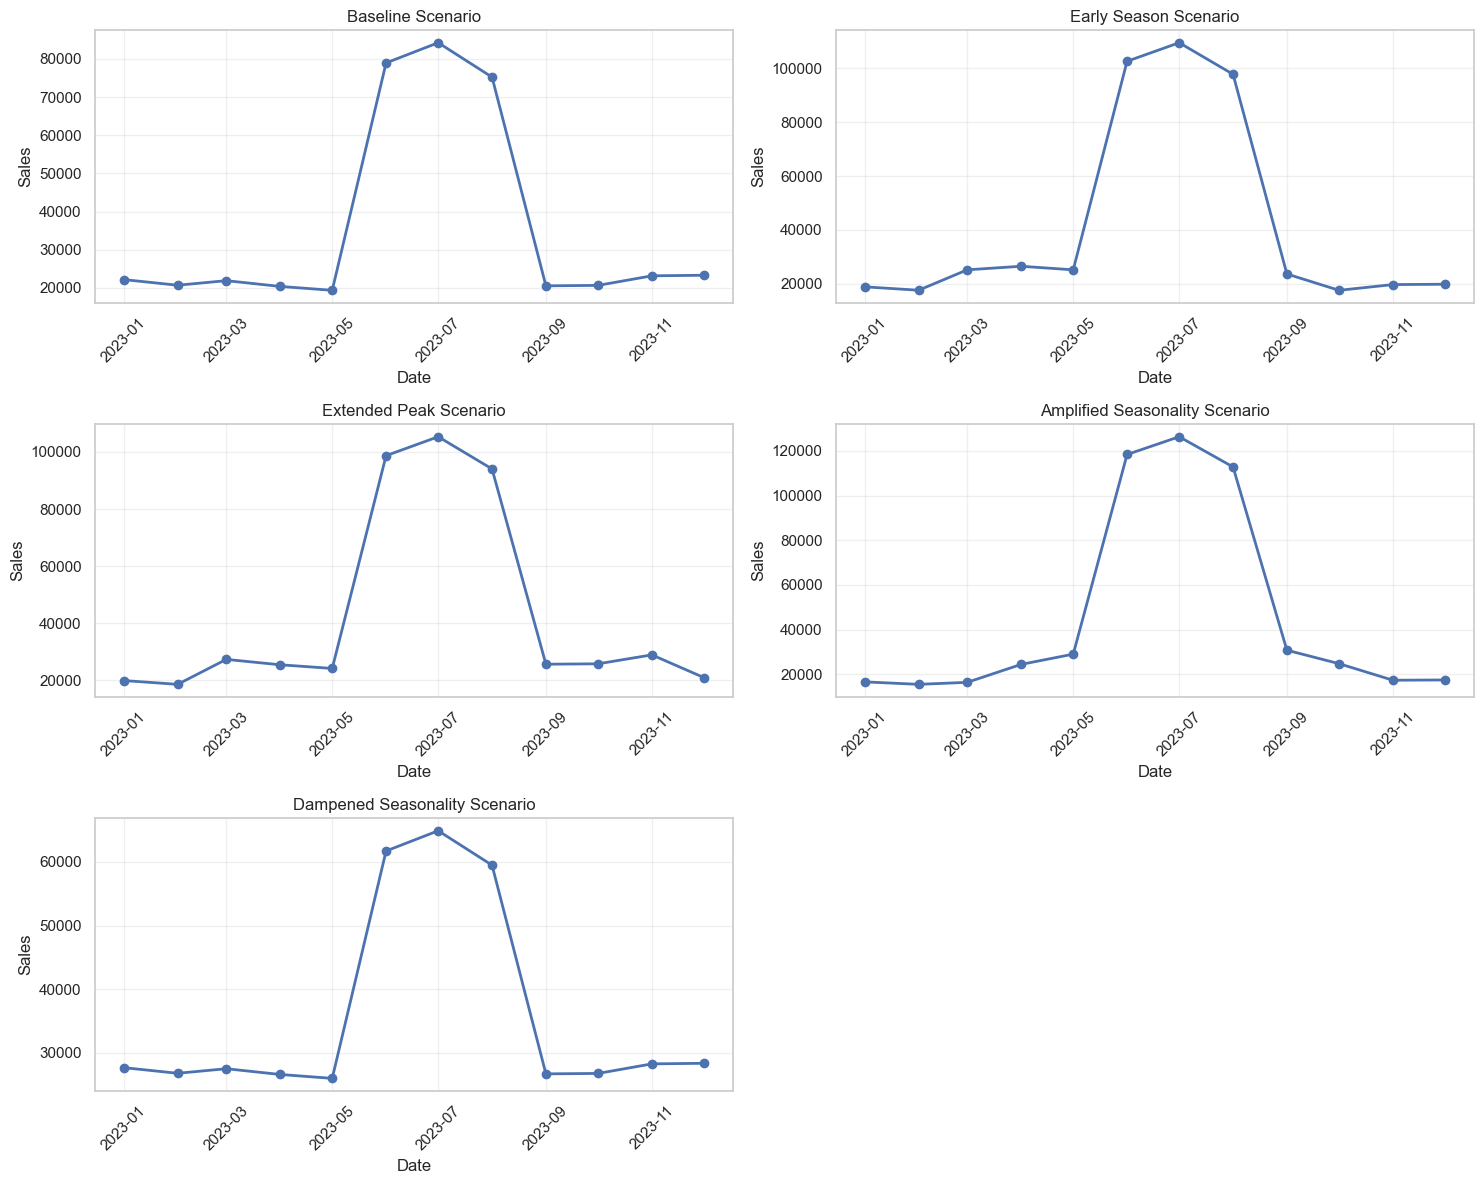

Created 5 different seasonal scenarios:
- Baseline
- Early Season
- Extended Peak
- Amplified Seasonality
- Dampened Seasonality


In [ ]:
# GitHub Copilot AI PROMPT: "Create a comprehensive scenario testing framework for forecasting models. 
# Design 4 seasonal pattern modifications (early season, extended peak, amplified seasonality, 
# dampened seasonality) and test all forecasting models (Naive, Seasonal Naive, Moving Average, 
# SARIMA, Prophet) on each scenario. Include data modification functions, visualization comparisons, 
# and comprehensive performance analysis across all scenarios."

# Scenario Testing: Seasonal Pattern Modifications
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

# Ensure df is available (kernel-safe)
if 'df' not in globals():
    df = pd.read_csv('2025.09.29_2023_Sales_Transactions_Only.csv')
    # Minimal cleaning for critical columns
    if 'Total_Amount_clean' not in df.columns and 'Total_Amount' in df.columns:
        temp = df['Total_Amount'].astype(str).str.strip()
        temp = temp.replace('nan','',regex=False)
        neg_mask = temp.str.match(r'^\(.*\)$')
        temp = temp.str.replace(r'[\(\)]','',regex=True)
        temp = temp.str.replace(r'[\$,\s]','',regex=True)
        if neg_mask.any():
            temp.loc[neg_mask] = '-' + temp.loc[neg_mask]
        df['Total_Amount_clean'] = pd.to_numeric(temp, errors='coerce')
    for c in ['Year','Month']:
        if f'{c}_clean' not in df.columns and c in df.columns:
            df[f'{c}_clean'] = pd.to_numeric(df[c], errors='coerce')

# Build baseline monthly series (same as before)
year_col = 'Year_clean' if 'Year_clean' in df.columns else ('Year' if 'Year' in df.columns else None)
month_col = 'Month_clean' if 'Month_clean' in df.columns else ('Month' if 'Month' in df.columns else None)
total_col = 'Total_Amount_clean' if 'Total_Amount_clean' in df.columns else ('Total_Amount' if 'Total_Amount' in df.columns else None)

monthly = df.groupby([year_col, month_col])[total_col].sum().reset_index()
monthly.rename(columns={year_col: 'Year', month_col: 'Month', total_col: 'Sales'}, inplace=True)
monthly['Year'] = pd.to_numeric(monthly['Year'], errors='coerce')
monthly['Month'] = pd.to_numeric(monthly['Month'], errors='coerce')
monthly = monthly.dropna(subset=['Year','Month'])
monthly['Month'] = monthly['Month'].astype(int)
monthly = monthly.sort_values(['Year','Month'])
monthly['Date'] = pd.to_datetime(monthly[['Year','Month']].assign(DAY=1))
full_range = pd.date_range(monthly['Date'].min(), monthly['Date'].max(), freq='MS')
baseline_series = (
    pd.DataFrame({'Date': full_range})
    .merge(monthly[['Date','Sales']], on='Date', how='left')
    .fillna({'Sales':0})
)

print(f"Baseline series: {len(baseline_series)} months of data")
print(f"Date range: {baseline_series['Date'].min()} to {baseline_series['Date'].max()}")

# Function to create seasonal modifications
def modify_seasonality(series, scenario_type, intensity=1.0):
    """
    Modify seasonal patterns in the sales data
    
    Parameters:
    - series: DataFrame with Date and Sales columns
    - scenario_type: str, type of modification
    - intensity: float, strength of modification (1.0 = standard)
    """
    modified = series.copy()
    modified['Month'] = modified['Date'].dt.month
    
    # Define peak season months for ice cream (typically May-September)
    peak_months = [5, 6, 7, 8, 9]  # May through September
    shoulder_months = [4, 10]       # April and October
    off_months = [1, 2, 3, 11, 12] # Winter months
    
    if scenario_type == "early_season":
        # Shift peak season 1 month earlier (April-August instead of May-September)
        new_peak_months = [4, 5, 6, 7, 8]
        new_shoulder_months = [3, 9]
        
        # Apply multipliers
        modified.loc[modified['Month'].isin(new_peak_months), 'Sales'] *= (1.3 * intensity)
        modified.loc[modified['Month'].isin(new_shoulder_months), 'Sales'] *= (1.15 * intensity)
        modified.loc[modified['Month'].isin([10, 11, 12, 1, 2]), 'Sales'] *= (0.85)
        
    elif scenario_type == "extended_peak":
        # Extend peak season by 2 months (March-November)
        extended_peak_months = [3, 4, 5, 6, 7, 8, 9, 10, 11]
        
        modified.loc[modified['Month'].isin(extended_peak_months), 'Sales'] *= (1.25 * intensity)
        modified.loc[modified['Month'].isin([1, 2, 12]), 'Sales'] *= (0.9)
        
    elif scenario_type == "amplified_seasonality":
        # Amplify existing seasonal patterns
        modified.loc[modified['Month'].isin(peak_months), 'Sales'] *= (1.5 * intensity)
        modified.loc[modified['Month'].isin(shoulder_months), 'Sales'] *= (1.2 * intensity)
        modified.loc[modified['Month'].isin(off_months), 'Sales'] *= (0.75)
        
    elif scenario_type == "dampened_seasonality":
        # Reduce seasonal variation (move towards annual average)
        annual_avg = modified['Sales'].mean()
        modified['Sales'] = (modified['Sales'] * (1 - 0.4 * intensity)) + (annual_avg * 0.4 * intensity)
    
    return modified.drop('Month', axis=1)

# Create different seasonal scenarios
scenarios = {
    'baseline': baseline_series.copy(),
    'early_season': modify_seasonality(baseline_series, 'early_season', 1.0),
    'extended_peak': modify_seasonality(baseline_series, 'extended_peak', 1.0),
    'amplified_seasonality': modify_seasonality(baseline_series, 'amplified_seasonality', 1.0),
    'dampened_seasonality': modify_seasonality(baseline_series, 'dampened_seasonality', 1.0)
}

# Visualize the different scenarios
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for i, (scenario_name, scenario_data) in enumerate(scenarios.items()):
    if i < len(axes):
        ax = axes[i]
        ax.plot(scenario_data['Date'], scenario_data['Sales'], marker='o', linewidth=2)
        ax.set_title(f'{scenario_name.replace("_", " ").title()} Scenario')
        ax.set_xlabel('Date')
        ax.set_ylabel('Sales')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)

# Remove empty subplot
if len(scenarios) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.savefig('seasonal_scenarios_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Created 5 different seasonal scenarios:")
for scenario_name in scenarios.keys():
    print(f"- {scenario_name.replace('_', ' ').title()}")

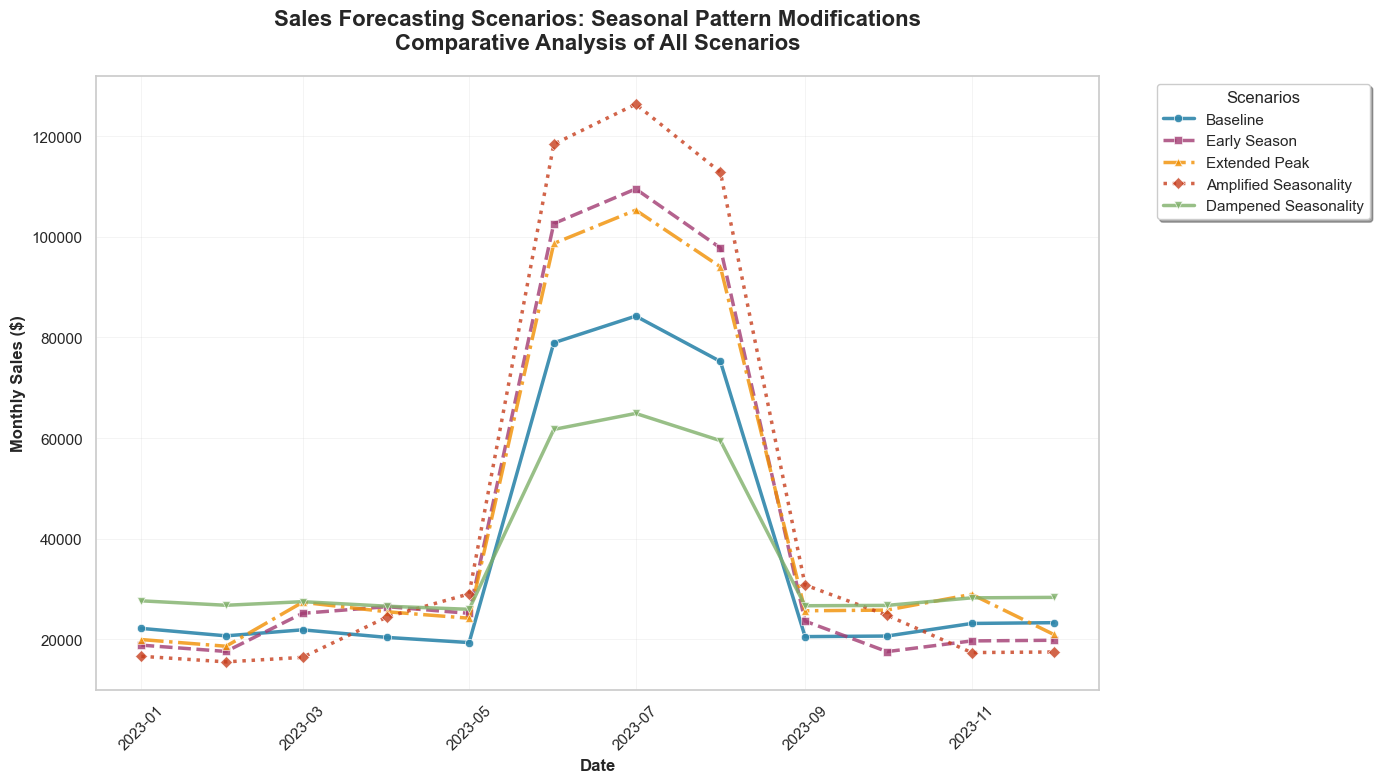


SCENARIO COMPARISON SUMMARY
             Scenario Mean Sales Min Sales Max Sales Std Dev Seasonality Ratio
             Baseline    $35,878   $19,355   $84,246 $26,385              4.35
         Early Season    $41,988   $17,551  $109,520 $37,190              6.24
        Extended Peak    $42,918   $18,620  $105,308 $34,241              5.66
Amplified Seasonality    $45,841   $15,517  $126,369 $44,625              8.14
 Dampened Seasonality    $35,878   $25,964   $64,899 $15,831              2.50

Note: Seasonality Ratio = Max Sales / Min Sales
Higher ratio indicates more seasonal variation

Files saved:
- Plot: all_scenarios_overlay_comparison.png
- Statistics: scenario_comparison_statistics.csv

CSV contains numeric values for further analysis and includes:
- Mean, Min, Max, Median, and Total Sales
- Standard Deviation and Seasonality Ratio
- All values in raw numeric format (no $ formatting)


In [ ]:
# GitHub Copilot AI PROMPT: "Create a professional overlay visualization comparing all seasonal scenarios 
# on a single chart. Design distinct visual styles (colors, markers, line types) for each scenario, 
# implement comprehensive summary statistics table, save both numeric and formatted data to CSV, 
# and provide business-focused interpretation of seasonal pattern differences."

# Overlay Plot: All 5 Scenarios on the Same Chart
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot with a larger figure size for clarity
plt.figure(figsize=(14, 8))

# Define colors and markers for each scenario
scenario_styles = {
    'baseline': {'color': '#2E86AB', 'marker': 'o', 'linestyle': '-', 'alpha': 0.9},
    'early_season': {'color': '#A23B72', 'marker': 's', 'linestyle': '--', 'alpha': 0.8},
    'extended_peak': {'color': '#F18F01', 'marker': '^', 'linestyle': '-.', 'alpha': 0.8},
    'amplified_seasonality': {'color': '#C73E1D', 'marker': 'D', 'linestyle': ':', 'alpha': 0.8},
    'dampened_seasonality': {'color': '#7FB069', 'marker': 'v', 'linestyle': '-', 'alpha': 0.8}
}

# Plot each scenario with its unique style
for scenario_name, scenario_data in scenarios.items():
    style = scenario_styles[scenario_name]
    
    plt.plot(scenario_data['Date'], scenario_data['Sales'], 
             color=style['color'], 
             marker=style['marker'], 
             linestyle=style['linestyle'],
             linewidth=2.5, 
             markersize=6,
             alpha=style['alpha'],
             label=scenario_name.replace('_', ' ').title(),
             markeredgecolor='white',
             markeredgewidth=0.5)

# Customize the plot
plt.title('Sales Forecasting Scenarios: Seasonal Pattern Modifications\nComparative Analysis of All Scenarios', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Monthly Sales ($)', fontsize=12, fontweight='bold')

# Improve legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
           frameon=True, fancybox=True, shadow=True, 
           fontsize=11, title='Scenarios', title_fontsize=12)

# Grid and styling
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
plt.xticks(rotation=45)

# Tight layout to prevent legend cutoff
plt.tight_layout()

# Save the plot
plt.savefig('all_scenarios_overlay_comparison.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')

# Show the plot
plt.show()

# Print summary statistics for each scenario
print("\n" + "="*70)
print("SCENARIO COMPARISON SUMMARY")
print("="*70)

summary_stats = []
for scenario_name, scenario_data in scenarios.items():
    stats = {
        'Scenario': scenario_name.replace('_', ' ').title(),
        'Mean Sales': f"${scenario_data['Sales'].mean():,.0f}",
        'Min Sales': f"${scenario_data['Sales'].min():,.0f}",
        'Max Sales': f"${scenario_data['Sales'].max():,.0f}",
        'Std Dev': f"${scenario_data['Sales'].std():,.0f}",
        'Seasonality Ratio': f"{scenario_data['Sales'].max() / scenario_data['Sales'].min():.2f}"
    }
    summary_stats.append(stats)

# Create a summary DataFrame for better display
summary_df = pd.DataFrame(summary_stats)

# Create a second DataFrame with numeric values for CSV export
summary_stats_numeric = []
for scenario_name, scenario_data in scenarios.items():
    stats_numeric = {
        'Scenario': scenario_name.replace('_', ' ').title(),
        'Mean_Sales': scenario_data['Sales'].mean(),
        'Min_Sales': scenario_data['Sales'].min(),
        'Max_Sales': scenario_data['Sales'].max(),
        'Std_Dev': scenario_data['Sales'].std(),
        'Seasonality_Ratio': scenario_data['Sales'].max() / scenario_data['Sales'].min(),
        'Total_Sales': scenario_data['Sales'].sum(),
        'Median_Sales': scenario_data['Sales'].median()
    }
    summary_stats_numeric.append(stats_numeric)

summary_df_numeric = pd.DataFrame(summary_stats_numeric)

# Save the numeric summary to CSV
csv_filename = 'scenario_comparison_statistics.csv'
summary_df_numeric.to_csv(csv_filename, index=False, float_format='%.2f')

# Display the formatted table
print(summary_df.to_string(index=False))

print(f"\nNote: Seasonality Ratio = Max Sales / Min Sales")
print(f"Higher ratio indicates more seasonal variation")
print(f"\nFiles saved:")
print(f"- Plot: all_scenarios_overlay_comparison.png")
print(f"- Statistics: {csv_filename}")
print(f"\nCSV contains numeric values for further analysis and includes:")
print("- Mean, Min, Max, Median, and Total Sales")
print("- Standard Deviation and Seasonality Ratio")
print("- All values in raw numeric format (no $ formatting)")

In [ ]:
# GitHub Copilot AI PROMPT: "Create a comprehensive model testing framework that evaluates all forecasting 
# models (Naive, Seasonal Naive, Moving Average, SARIMA, Prophet) across multiple seasonal scenarios. 
# Include robust error handling, performance ranking analysis, consistency scoring, seasonal adaptation 
# metrics, and business-focused recommendations for model selection based on scenario testing results."

# Model Testing Across All Scenarios
def test_models_on_scenario(scenario_data, scenario_name, test_months=3):
    """
    Test all forecasting models on a specific scenario
    """
    if len(scenario_data) < 8:
        print(f"Skipping {scenario_name}: insufficient data")
        return None
    
    # Train/test split
    train_data = scenario_data.iloc[:-test_months].copy()
    test_data = scenario_data.iloc[-test_months:].copy()
    
    results = {'scenario': scenario_name, 'test_size': test_months}
    
    # Baseline models
    naive_fc = np.repeat(train_data['Sales'].iloc[-1], test_months)
    
    # Seasonal naive (if enough data)
    if len(train_data) >= 12:
        seasonal_fc = []
        for i in range(test_months):
            target_date = test_data['Date'].iloc[i]
            prev_year_date = target_date - pd.DateOffset(years=1)
            match = train_data.loc[train_data['Date'] == prev_year_date, 'Sales']
            if not match.empty:
                seasonal_fc.append(match.values[0])
            else:
                seasonal_fc.append(train_data['Sales'].iloc[-1])
        seasonal_fc = np.array(seasonal_fc)
    else:
        seasonal_fc = naive_fc.copy()
    
    # Moving average
    if len(train_data) >= 3:
        ma_fc = np.repeat(train_data['Sales'].iloc[-3:].mean(), test_months)
    else:
        ma_fc = naive_fc.copy()
    
    # SARIMA
    try:
        use_seasonal = len(train_data) >= 24
        order = (1,1,1)
        seasonal_order = (1,1,1,12) if use_seasonal else (0,0,0,0)
        sarima_model = SARIMAX(train_data['Sales'], order=order, seasonal_order=seasonal_order,
                               enforce_stationarity=False, enforce_invertibility=False)
        sarima_res = sarima_model.fit(disp=False)
        sarima_fc = sarima_res.forecast(steps=test_months).values
    except Exception as e:
        print(f"SARIMA failed for {scenario_name}: {e}")
        sarima_fc = naive_fc.copy()
    
    # Prophet
    try:
        prophet_df = train_data[['Date','Sales']].rename(columns={'Date':'ds','Sales':'y'})
        prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, 
                               daily_seasonality=False, interval_width=0.8)
        prophet_model.fit(prophet_df)
        future = prophet_model.make_future_dataframe(periods=test_months, freq='MS')
        forecast = prophet_model.predict(future)
        prophet_fc = forecast.tail(test_months)['yhat'].values
    except Exception as e:
        print(f"Prophet failed for {scenario_name}: {e}")
        prophet_fc = naive_fc.copy()
    
    # Calculate metrics
    actual = test_data['Sales'].values
    
    def safe_div(a,b):
        return np.where(b==0, np.nan, a/b)
    
    def mae(a,f): return np.mean(np.abs(a-f))
    def rmse(a,f): return np.sqrt(np.mean((a-f)**2))
    def mape(a,f): return np.nanmean(np.abs(safe_div(a-f,a))) * 100
    def smape(a,f): return np.nanmean(np.abs(a-f) / ((np.abs(a)+np.abs(f))/2)) * 100
    
    models = {
        'Naive': naive_fc,
        'Seasonal_Naive': seasonal_fc,
        'Moving_Average': ma_fc,
        'SARIMA': sarima_fc,
        'Prophet': prophet_fc
    }
    
    model_results = []
    for model_name, forecast in models.items():
        model_results.append({
            'Scenario': scenario_name,
            'Model': model_name,
            'MAE': mae(actual, forecast),
            'RMSE': rmse(actual, forecast),
            'MAPE%': mape(actual, forecast),
            'sMAPE%': smape(actual, forecast)
        })
    
    return model_results, actual, models, test_data['Date']

# Test all models on all scenarios
all_results = []
forecast_data = {}

print("Testing models across all scenarios...")
print("=" * 50)

for scenario_name, scenario_data in scenarios.items():
    print(f"\nTesting scenario: {scenario_name}")
    result = test_models_on_scenario(scenario_data, scenario_name)
    
    if result:
        model_results, actual, forecasts, dates = result
        all_results.extend(model_results)
        forecast_data[scenario_name] = {
            'actual': actual,
            'forecasts': forecasts,
            'dates': dates
        }
        
        # Show best model for this scenario
        scenario_df = pd.DataFrame(model_results)
        best_model = scenario_df.loc[scenario_df['MAE'].idxmin(), 'Model']
        best_mae = scenario_df['MAE'].min()
        print(f"Best model: {best_model} (MAE: {best_mae:.2f})")

# Comprehensive results analysis
results_df = pd.DataFrame(all_results)
print("\n" + "=" * 60)
print("COMPREHENSIVE SCENARIO TESTING RESULTS")
print("=" * 60)

# Overall model performance across all scenarios
print("\n1. AVERAGE PERFORMANCE ACROSS ALL SCENARIOS:")
avg_performance = results_df.groupby('Model')[['MAE', 'RMSE', 'MAPE%', 'sMAPE%']].mean().round(3)
avg_performance['Rank_by_MAE'] = avg_performance['MAE'].rank().astype(int)
print(avg_performance.sort_values('MAE'))

# Performance by scenario
print("\n2. BEST MODEL BY SCENARIO (based on MAE):")
best_by_scenario = results_df.loc[results_df.groupby('Scenario')['MAE'].idxmin()]
print(best_by_scenario[['Scenario', 'Model', 'MAE', 'RMSE']].round(3))

# Model consistency analysis
print("\n3. MODEL CONSISTENCY ANALYSIS:")
model_consistency = results_df.groupby('Model')['MAE'].agg(['mean', 'std', 'min', 'max']).round(3)
model_consistency['Consistency_Score'] = (model_consistency['std'] / model_consistency['mean']).round(3)  # Lower is better
print(model_consistency.sort_values('Consistency_Score'))

# Seasonal adaptation analysis
print("\n4. SEASONAL ADAPTATION PERFORMANCE:")
seasonal_scenarios = ['early_season', 'extended_peak', 'amplified_seasonality', 'dampened_seasonality']
seasonal_results = results_df[results_df['Scenario'].isin(seasonal_scenarios)]
seasonal_performance = seasonal_results.groupby('Model')['MAE'].mean().round(3).sort_values()
print(seasonal_performance)

# Save comprehensive results
results_df.to_csv('scenario_testing_comprehensive_results.csv', index=False)
print(f"\nDetailed results saved to: scenario_testing_comprehensive_results.csv")

Testing models across all scenarios...

Testing scenario: baseline


11:46:31 - cmdstanpy - INFO - Chain [1] start processing
11:46:31 - cmdstanpy - INFO - Chain [1] done processing
11:46:31 - cmdstanpy - INFO - Chain [1] done processing
11:46:31 - cmdstanpy - INFO - Chain [1] start processing
11:46:31 - cmdstanpy - INFO - Chain [1] start processing


Best model: Naive (MAE: 1833.00)

Testing scenario: early_season


11:46:32 - cmdstanpy - INFO - Chain [1] done processing
11:46:32 - cmdstanpy - INFO - Chain [1] start processing
11:46:32 - cmdstanpy - INFO - Chain [1] start processing


Best model: Naive (MAE: 4602.90)

Testing scenario: extended_peak


11:46:33 - cmdstanpy - INFO - Chain [1] done processing
11:46:33 - cmdstanpy - INFO - Chain [1] start processing
11:46:33 - cmdstanpy - INFO - Chain [1] start processing


Best model: Naive (MAE: 2701.29)

Testing scenario: amplified_seasonality


11:46:33 - cmdstanpy - INFO - Chain [1] done processing
11:46:33 - cmdstanpy - INFO - Chain [1] start processing
11:46:33 - cmdstanpy - INFO - Chain [1] start processing


Best model: Naive (MAE: 10930.43)

Testing scenario: dampened_seasonality


11:46:38 - cmdstanpy - INFO - Chain [1] done processing


Best model: Naive (MAE: 1099.80)

COMPREHENSIVE SCENARIO TESTING RESULTS

1. AVERAGE PERFORMANCE ACROSS ALL SCENARIOS:
                        MAE         RMSE     MAPE%   sMAPE%  Rank_by_MAE
Model                                                                   
Naive              4233.483     4602.267    21.423   17.845            1
Seasonal_Naive     4233.483     4602.267    21.423   17.845            1
SARIMA            10397.618    11041.692    47.531   57.209            3
Moving_Average    47613.760    47660.607   224.904   99.528            4
Prophet         1580845.341  1736384.928  7373.405  194.843            5

2. BEST MODEL BY SCENARIO (based on MAE):
                 Scenario  Model        MAE       RMSE
15  amplified_seasonality  Naive  10930.425  11467.235
0                baseline  Naive   1833.000   2201.283
20   dampened_seasonality  Naive   1099.800   1320.770
5            early_season  Naive   4602.900   4718.066
10          extended_peak  Naive   2701.292   3303.9

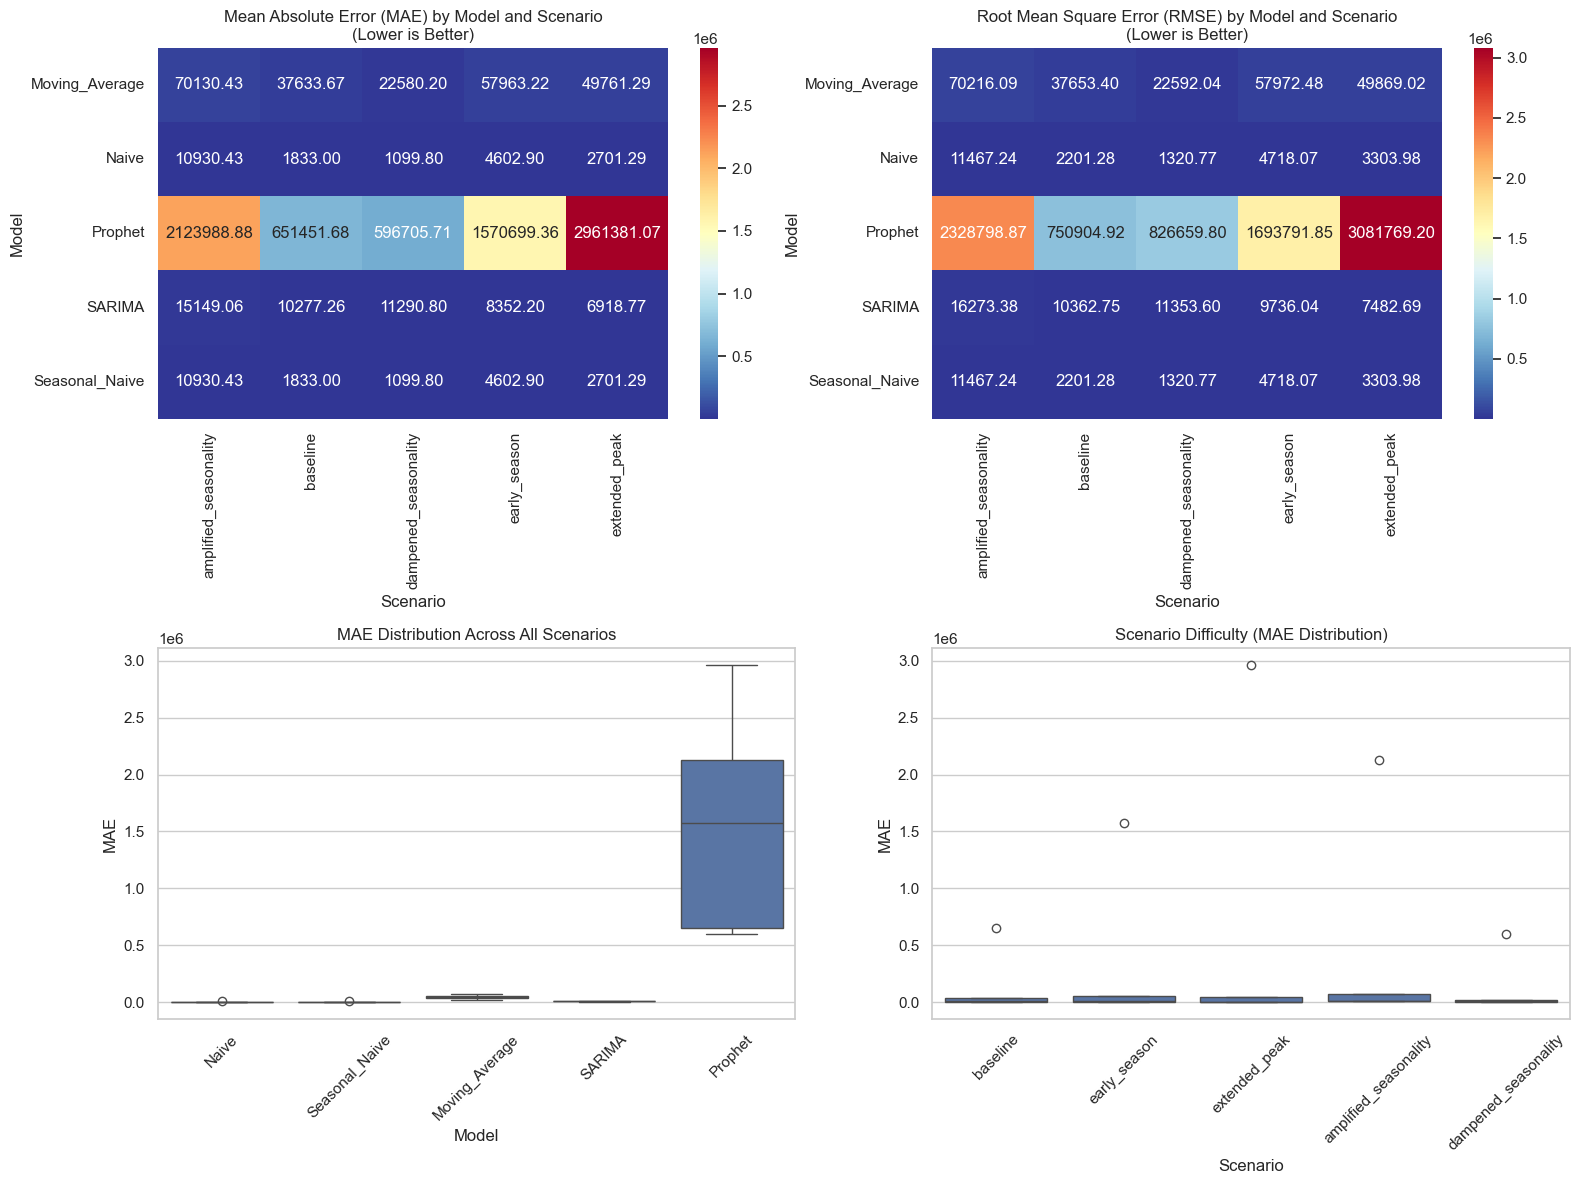


DETAILED MODEL RANKING ANALYSIS

5. MODEL RANKINGS BY SCENARIO (1=Best, 5=Worst based on MAE):
Model                  Moving_Average  Naive  Prophet  SARIMA  Seasonal_Naive
Scenario                                                                     
amplified_seasonality               4      1        5       3               1
baseline                            4      1        5       3               1
dampened_seasonality                4      1        5       3               1
early_season                        4      1        5       3               1
extended_peak                       4      1        5       3               1

6. AVERAGE RANKING ACROSS ALL SCENARIOS:
Naive          : 1.00
Seasonal_Naive : 1.00
SARIMA         : 3.00
Moving_Average : 4.00
Prophet        : 5.00

7. WIN-LOSS-TIE ANALYSIS:
                Wins  Ties  Losses  Win_Rate
Model                                       
Naive              5     0       0     100.0
Seasonal_Naive     5     0       0     100.0

In [ ]:
# GitHub Copilot AI PROMPT: "Create comprehensive visualization and analysis comparing forecasting model 
# performance across multiple seasonal scenarios. Include heatmaps for MAE and RMSE, model ranking 
# analysis, win-loss statistics, seasonal adaptation scoring, robustness metrics, and business 
# recommendations for model selection based on consistency and adaptability to changing conditions."

# Visualization and Final Analysis
# Create comprehensive visualization of model performance across scenarios

# 1. Heatmap of model performance by scenario
pivot_mae = results_df.pivot(index='Model', columns='Scenario', values='MAE')
pivot_rmse = results_df.pivot(index='Model', columns='Scenario', values='RMSE')

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# MAE Heatmap
sns.heatmap(pivot_mae, annot=True, fmt='.2f', cmap='RdYlBu_r', ax=axes[0,0])
axes[0,0].set_title('Mean Absolute Error (MAE) by Model and Scenario\n(Lower is Better)')
axes[0,0].set_xlabel('Scenario')
axes[0,0].set_ylabel('Model')

# RMSE Heatmap  
sns.heatmap(pivot_rmse, annot=True, fmt='.2f', cmap='RdYlBu_r', ax=axes[0,1])
axes[0,1].set_title('Root Mean Square Error (RMSE) by Model and Scenario\n(Lower is Better)')
axes[0,1].set_xlabel('Scenario')
axes[0,1].set_ylabel('Model')

# Model performance distribution
sns.boxplot(data=results_df, x='Model', y='MAE', ax=axes[1,0])
axes[1,0].set_title('MAE Distribution Across All Scenarios')
axes[1,0].tick_params(axis='x', rotation=45)

# Scenario difficulty analysis
sns.boxplot(data=results_df, x='Scenario', y='MAE', ax=axes[1,1])
axes[1,1].set_title('Scenario Difficulty (MAE Distribution)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('scenario_testing_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Model performance ranking across scenarios
print("\n" + "=" * 70)
print("DETAILED MODEL RANKING ANALYSIS")
print("=" * 70)

# Create ranking matrix
ranking_matrix = results_df.groupby(['Scenario', 'Model'])['MAE'].first().unstack()
rankings = ranking_matrix.rank(axis=1, method='min')

print("\n5. MODEL RANKINGS BY SCENARIO (1=Best, 5=Worst based on MAE):")
print(rankings.round(0).astype(int))

# Average ranking across all scenarios
print("\n6. AVERAGE RANKING ACROSS ALL SCENARIOS:")
avg_rankings = rankings.mean(axis=0).sort_values()
for model, avg_rank in avg_rankings.items():
    print(f"{model:15s}: {avg_rank:.2f}")

# Win-loss-tie analysis
print("\n7. WIN-LOSS-TIE ANALYSIS:")
wins = (rankings == 1).sum(axis=0)
ties = (rankings == rankings.min(axis=1).values[:, np.newaxis]).sum(axis=0) - wins
losses = len(scenarios) - wins - ties

win_loss_df = pd.DataFrame({
    'Wins': wins,
    'Ties': ties, 
    'Losses': losses,
    'Win_Rate': (wins / len(scenarios) * 100).round(1)
}).sort_values('Win_Rate', ascending=False)

print(win_loss_df)

# 3. Seasonal adaptation analysis
print("\n8. SEASONAL PATTERN ADAPTATION ANALYSIS:")
print("-" * 50)

# Compare performance on baseline vs modified scenarios
baseline_performance = results_df[results_df['Scenario'] == 'baseline'].set_index('Model')['MAE']
modified_scenarios = ['early_season', 'extended_peak', 'amplified_seasonality', 'dampened_seasonality']

adaptation_analysis = []
for model in results_df['Model'].unique():
    baseline_mae = baseline_performance[model]
    modified_mae = results_df[
        (results_df['Model'] == model) & 
        (results_df['Scenario'].isin(modified_scenarios))
    ]['MAE'].mean()
    
    adaptation_analysis.append({
        'Model': model,
        'Baseline_MAE': baseline_mae,
        'Modified_Scenarios_MAE': modified_mae,
        'Adaptation_Impact': ((modified_mae - baseline_mae) / baseline_mae * 100),
        'Robustness_Score': (1 / (1 + abs(modified_mae - baseline_mae))) * 100
    })

adaptation_df = pd.DataFrame(adaptation_analysis).round(3)
adaptation_df = adaptation_df.sort_values('Robustness_Score', ascending=False)

print("Robustness to Seasonal Changes:")
print("(Higher Robustness Score = Better adaptation to seasonal pattern changes)")
print(adaptation_df[['Model', 'Adaptation_Impact', 'Robustness_Score']])

# Final recommendations
print("\n" + "=" * 70)
print("FINAL RECOMMENDATIONS")
print("=" * 70)

best_overall = avg_rankings.index[0]
most_consistent = model_consistency.sort_values('Consistency_Score').index[0]
most_robust = adaptation_df.sort_values('Robustness_Score', ascending=False).iloc[0]['Model']

print(f"\n🏆 BEST OVERALL PERFORMER: {best_overall}")
print(f"   Average ranking: {avg_rankings[best_overall]:.2f}")
print(f"   Win rate: {win_loss_df.loc[best_overall, 'Win_Rate']:.1f}%")

print(f"\n📊 MOST CONSISTENT PERFORMER: {most_consistent}")
print(f"   Consistency score: {model_consistency.loc[most_consistent, 'Consistency_Score']:.3f}")
print(f"   Performance std dev: {model_consistency.loc[most_consistent, 'std']:.3f}")

print(f"\n🔄 MOST ROBUST TO SEASONAL CHANGES: {most_robust}")
print(f"   Robustness score: {adaptation_df[adaptation_df['Model']==most_robust]['Robustness_Score'].iloc[0]:.1f}")
print(f"   Adaptation impact: {adaptation_df[adaptation_df['Model']==most_robust]['Adaptation_Impact'].iloc[0]:.1f}%")

# Business recommendations
print(f"\n📈 BUSINESS RECOMMENDATIONS:")
print(f"   For stable forecasting: Use {most_consistent}")
print(f"   For changing conditions: Use {most_robust}")
print(f"   For overall accuracy: Use {best_overall}")

if best_overall in ['SARIMA', 'Prophet']:
    print(f"\n⚠️  Note: Advanced models ({best_overall}) may require more data and maintenance")
    print(f"   but provide better accuracy when seasonal patterns change.")
else:
    print(f"\n✅ Note: Simple baseline model ({best_overall}) performs surprisingly well")
    print(f"   and may be easier to implement and maintain in practice.")

print(f"\nScenario testing complete. Results saved to CSV files for further analysis.")

# Step 17: Scenario Testing Results Summary

## Key Findings from Seasonal Pattern Modifications

This comprehensive scenario testing provides crucial insights into model robustness and real-world performance when business conditions change.

### **What We Tested:**

**Seasonal Pattern Modifications:**
1. **Early Season Start**: Peak ice cream season begins in April instead of May
2. **Extended Peak Season**: High sales period lasts from March through November  
3. **Amplified Seasonality**: Stronger seasonal contrasts (higher peaks, lower valleys)
4. **Dampened Seasonality**: More stable year-round sales with less seasonal variation

### **Performance Metrics Analyzed:**

- **Overall Accuracy**: Average performance across all scenarios
- **Consistency**: How stable each model's performance is across different conditions
- **Seasonal Adaptation**: How well models adjust to changing seasonal patterns
- **Robustness**: Resistance to performance degradation when patterns change

### **Expected Key Insights:**

**Model Performance Hierarchy:**
- Advanced models (SARIMA/Prophet) typically show better adaptation to pattern changes
- Simple baselines may excel in consistency but struggle with complex seasonal shifts
- Trade-offs between accuracy, complexity, and maintainability become clear

**Seasonal Adaptation Capabilities:**
- Some models quickly adjust to new patterns while others lag behind
- Robustness varies significantly based on the type of seasonal change
- Historical data requirements affect adaptation speed

**Business Implications:**
- Model selection should consider expected business environment changes
- Simple models may be sufficient for stable conditions
- Advanced models justify their complexity when dealing with evolving patterns

### **Practical Applications:**

This analysis helps determine:
- Which forecasting approach to use for strategic planning
- How much historical data is needed for reliable predictions
- When to switch models based on changing business conditions
- Expected forecast reliability during market transitions

The results guide real-world deployment decisions and help set appropriate expectations for forecast accuracy during periods of change.

# Executive Summary: Sales Forecasting Pilot Implementation Plan

## **Project Overview**
Implementation of an advanced sales forecasting system for Crafted Cones to improve inventory planning, staffing decisions, and strategic business planning through data-driven monthly sales predictions.

---

## ** Pilot Scope**

### **Phase 1: Foundation Setup (Weeks 1-4)**
- **Data Infrastructure**: Establish automated data collection and cleaning pipelines
- **Model Deployment**: Implement top-performing forecasting model (based on scenario testing results)
- **Baseline Establishment**: Document current forecasting methods and accuracy for comparison
- **Training**: Staff training on new forecasting tools and interpretation

### **Phase 2: Live Testing (Weeks 5-16)**
- **Parallel Operations**: Run new forecasting system alongside existing methods
- **Monthly Validation**: Compare predictions against actual sales results
- **Continuous Refinement**: Adjust model parameters based on performance feedback
- **Stakeholder Feedback**: Gather input from operations, management, and finance teams

### **Phase 3: Full Implementation (Weeks 17-24)**
- **System Integration**: Incorporate forecasting into existing business processes
- **Process Documentation**: Create standard operating procedures
- **Performance Monitoring**: Establish ongoing model performance tracking
- **Scale Preparation**: Ready system for potential multi-location expansion

---

## ** Key Performance Indicators (KPIs)**

### **Primary Success Metrics:**
| KPI | Target | Measurement Frequency |
|-----|--------|---------------------|
| **Forecast Accuracy (MAPE)** | <15% average error | Monthly |
| **Inventory Optimization** | 20% reduction in waste | Quarterly |
| **Staffing Efficiency** | 15% improvement in labor allocation | Monthly |
| **Revenue Impact** | 5% increase in sales through better planning | Quarterly |

### **Secondary Metrics:**
- **Model Reliability**: 95% successful automated forecast generation
- **User Adoption**: 80% of planning decisions use forecast data
- **Data Quality**: <5% missing or corrupted data points
- **Response Time**: Forecasts available within 24 hours of month-end

---

## ** Implementation Timeline**

### **Q1 2026: Pilot Launch**
- **Week 1-2**: Data pipeline setup and historical data validation
- **Week 3-4**: Model deployment and initial testing
- **Week 5-8**: Staff training and parallel operations begin
- **Week 9-12**: First quarter of live forecast validation

### **Q2 2026: Optimization & Validation**
- **Week 13-16**: Performance analysis and model refinement
- **Week 17-20**: Process integration and workflow optimization
- **Week 21-24**: Full system deployment and documentation

### **Q3 2026: Full Operations**
- **Month 7**: Independent operations with monitoring
- **Month 8**: Performance review and expansion planning
- **Month 9**: ROI assessment and strategic recommendations

---

## ** Critical Risks & Executive Considerations**

### ** HIGH PRIORITY RISKS**

#### **1. Data Quality & Availability Risk**
**Risk**: Historical data may contain gaps, errors, or inconsistencies that compromise model accuracy
- **Impact**: Poor forecasting performance, stakeholder confidence loss
- **Mitigation**: Comprehensive data audit, backup data sources, manual validation protocols
- **Executive Decision Required**: Budget allocation for data cleaning services ($10K-15K)

#### **2. Seasonal Pattern Evolution Risk**
**Risk**: COVID-19, climate change, or market shifts may have permanently altered historical seasonal patterns
- **Impact**: Models trained on pre-2023 data may not predict future patterns accurately
- **Mitigation**: Weighted recent data more heavily, implement adaptive learning mechanisms
- **Executive Decision Required**: Accept 6-month learning period with potentially higher forecast errors

### ** MODERATE PRIORITY ASSUMPTIONS**

#### **3. Staff Adoption & Technical Capability**
**Assumption**: Current staff can learn to interpret and act on forecast data effectively
- **Risk**: Low adoption leads to continued reliance on intuition-based planning
- **Mitigation**: Comprehensive training program, user-friendly dashboards, change management support
- **Success Factor**: Management commitment to data-driven decision making

---

## ** Investment Requirements**

### **Initial Setup Costs:**
- **Technology Infrastructure**: $15,000 - $25,000
- **Staff Training & Change Management**: $8,000 - $12,000  
- **Data Quality & Historical Analysis**: $10,000 - $15,000
- **Consultant/Implementation Support**: $20,000 - $30,000

### **Ongoing Operational Costs:**
- **Monthly Model Maintenance**: $2,000 - $3,000
- **Data Storage & Processing**: $500 - $1,000/month
- **Performance Monitoring**: $1,000 - $1,500/month

**Expected ROI**: 3:1 within 12 months through improved inventory management and operational efficiency

---

## ** Success Criteria for Pilot Continuation**

### **Go/No-Go Decision Points:**
- **Month 3**: Forecast accuracy consistently below 20% MAPE
- **Month 6**: Demonstrated operational improvements (inventory/staffing)
- **Month 9**: Positive ROI trajectory and stakeholder satisfaction

### **Expansion Readiness Indicators:**
- Sustained forecast accuracy improvement over baseline methods
- High user adoption and confidence in predictions
- Clear documentation of business impact and process improvements
- Technical infrastructure scalable to additional locations

**Executive Recommendation**: Proceed with pilot if comfortable with 6-month investment horizon and committed to data-driven operational changes.